In [1]:
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import multiprocessing as mp
from scipy.ndimage import convolve

# Global variables (unchanged)
R_ARENA_SIZE = 2 * 1.231
R_EPUCK_RADIUS = 0.035
R_DT = 0.1 
optimal_bin_widths = 0.2043  # Previously computed optimal bin widths

def read_best_fsms(file_path='best_fsms.csv'):
    return pd.read_csv(file_path, index_col=0)

best_fsms = read_best_fsms()

import joblib

# Define file paths
all_mission_data_path = 'all_mission_data.joblib'
mission_vector_fields_path = 'mission_vector_fields.joblib'

# Load all_mission_data
all_mission_data = joblib.load(all_mission_data_path)
print(f"Loaded all_mission_data from {all_mission_data_path}")

Loaded all_mission_data from all_mission_data.joblib


Generating mission vector fields:   0%|          | 0/5 [00:00<?, ?it/s]


Mission: DirectionalGate_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 132
Mean velocity magnitude: 0.0525

Mission: Foraging_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 127
Mean velocity magnitude: 0.0349

Mission: Homing_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 125
Mean velocity magnitude: 0.0339

Mission: Shelter_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 124
Mean velocity magnitude: 0.0399

Mission: XOR-Aggregation_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 126
Mean velocity magnitude: 0.0121


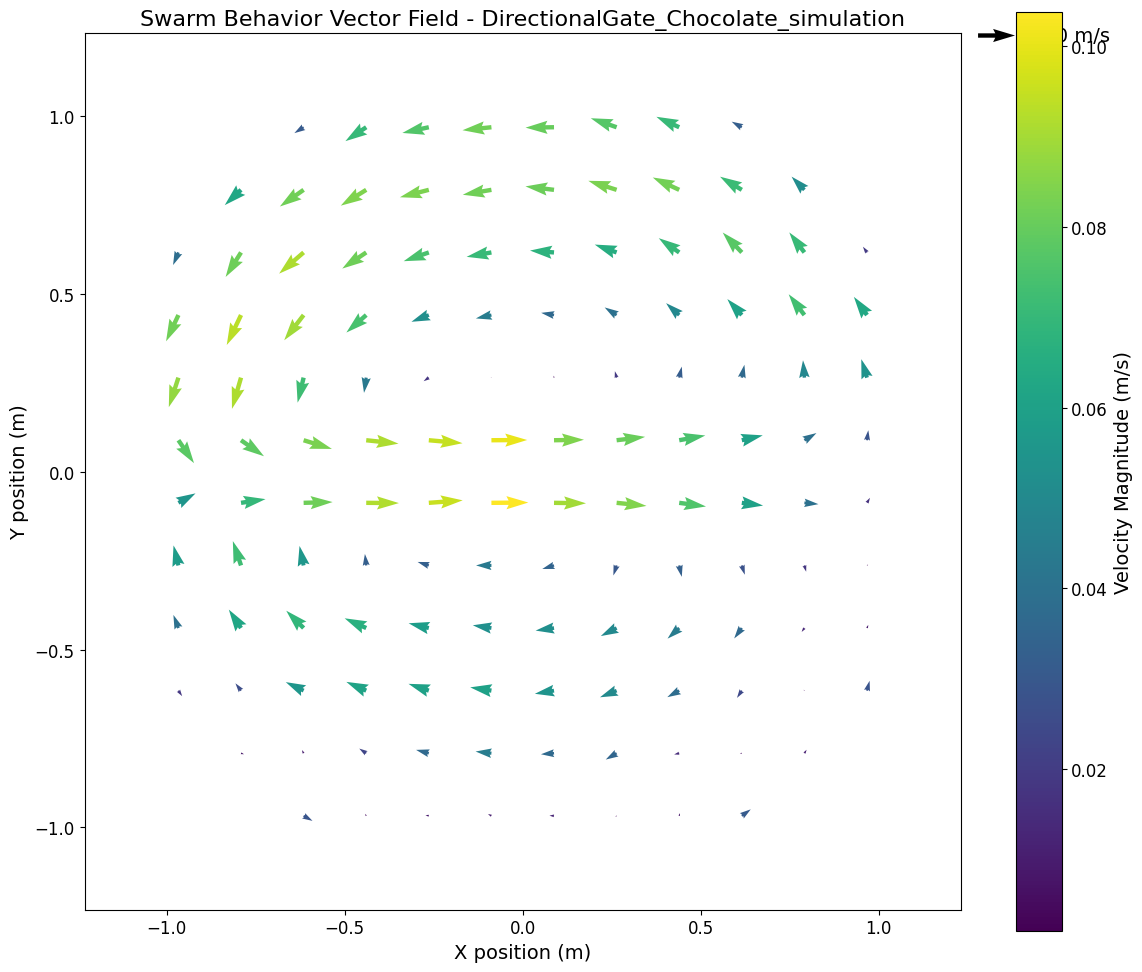

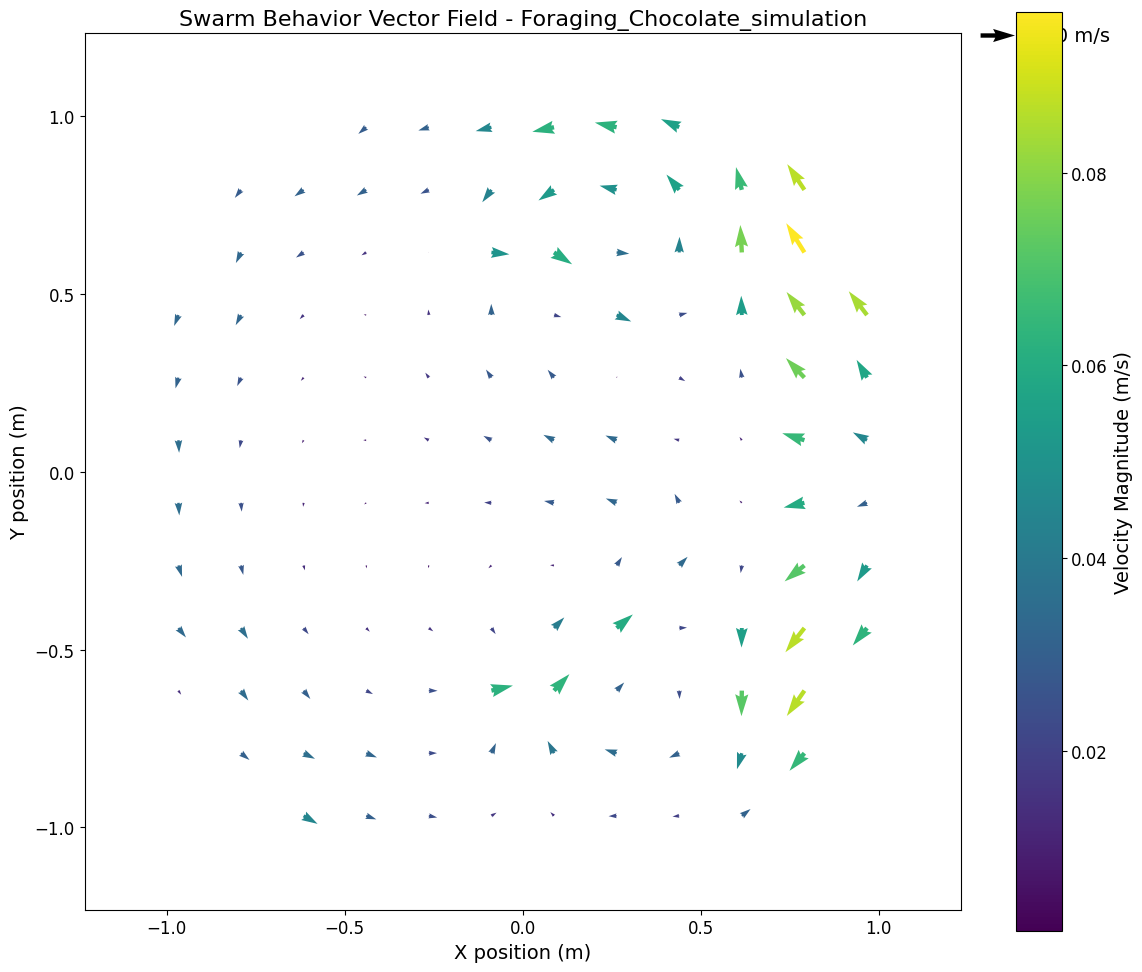

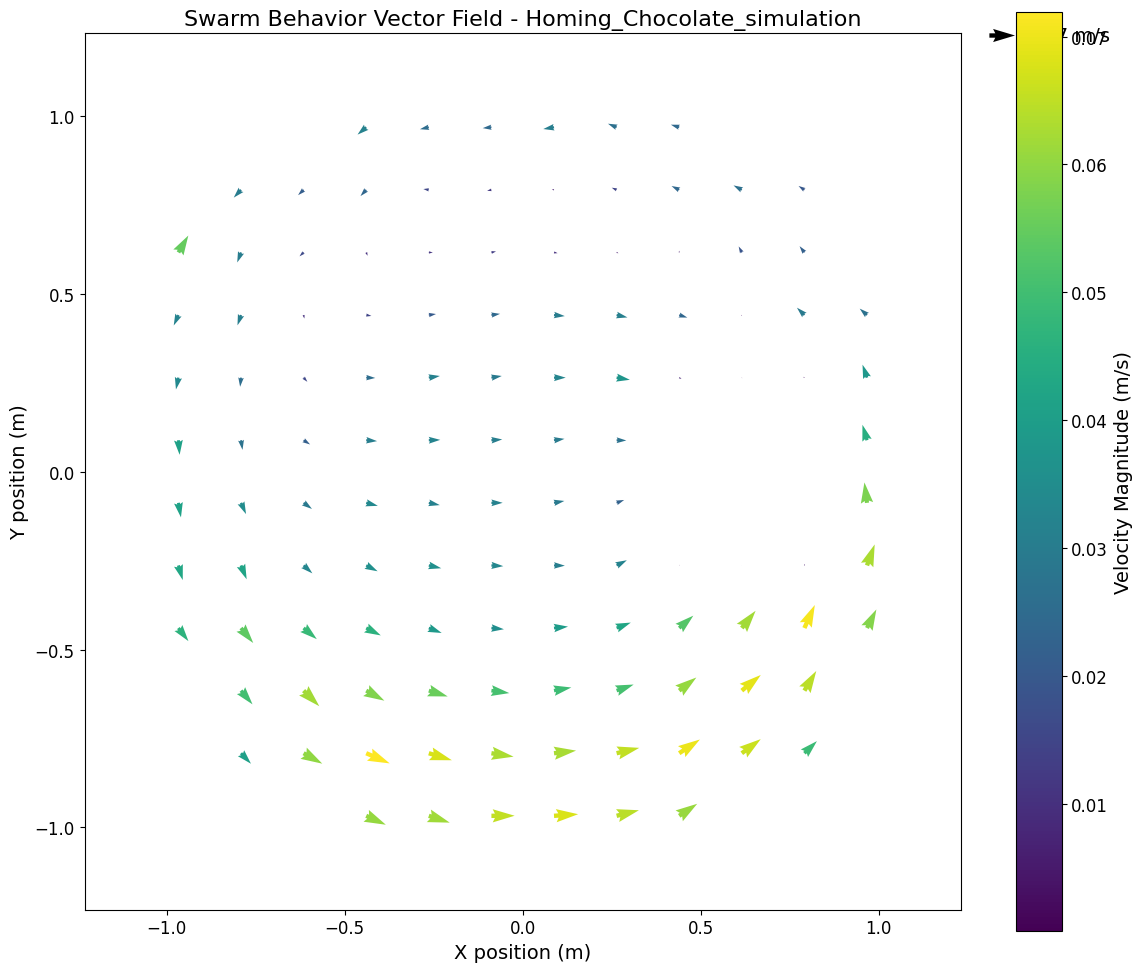

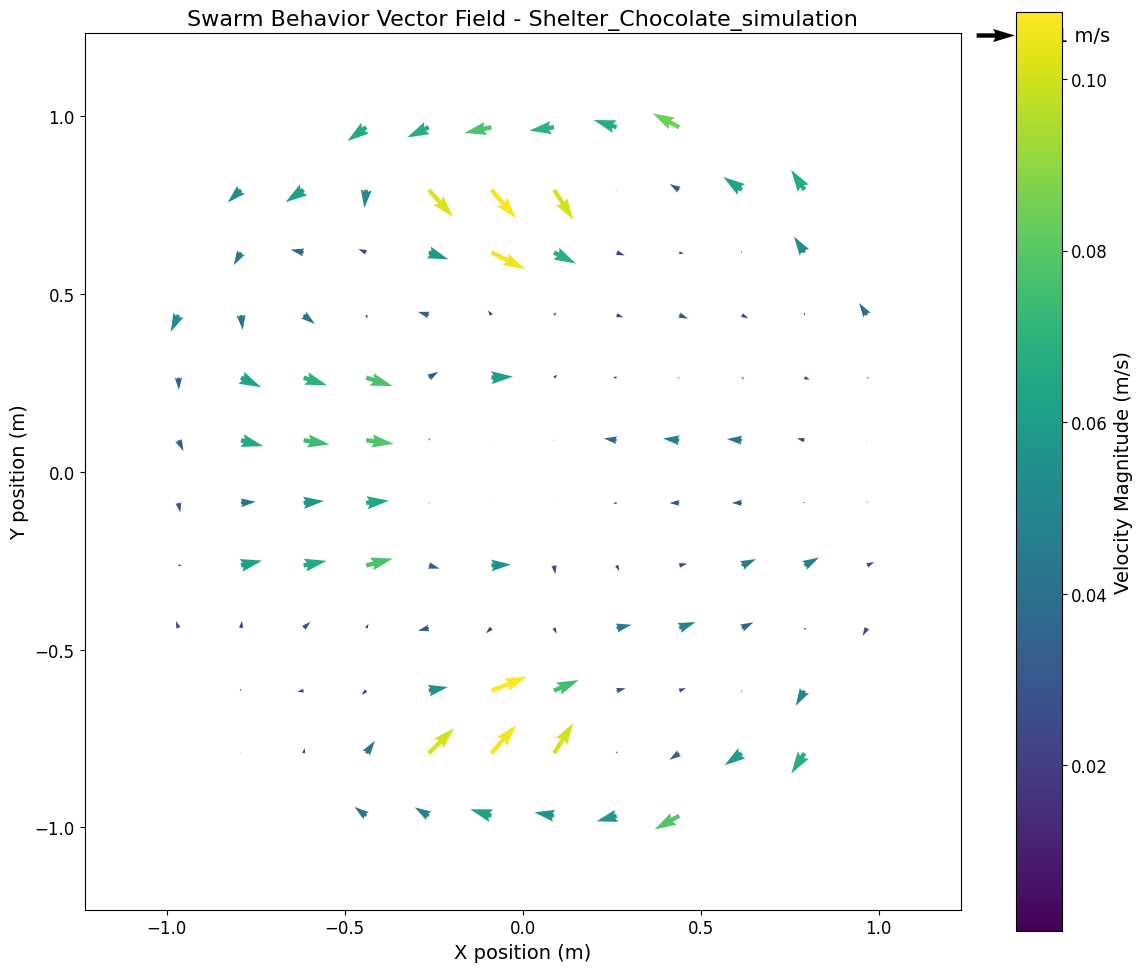

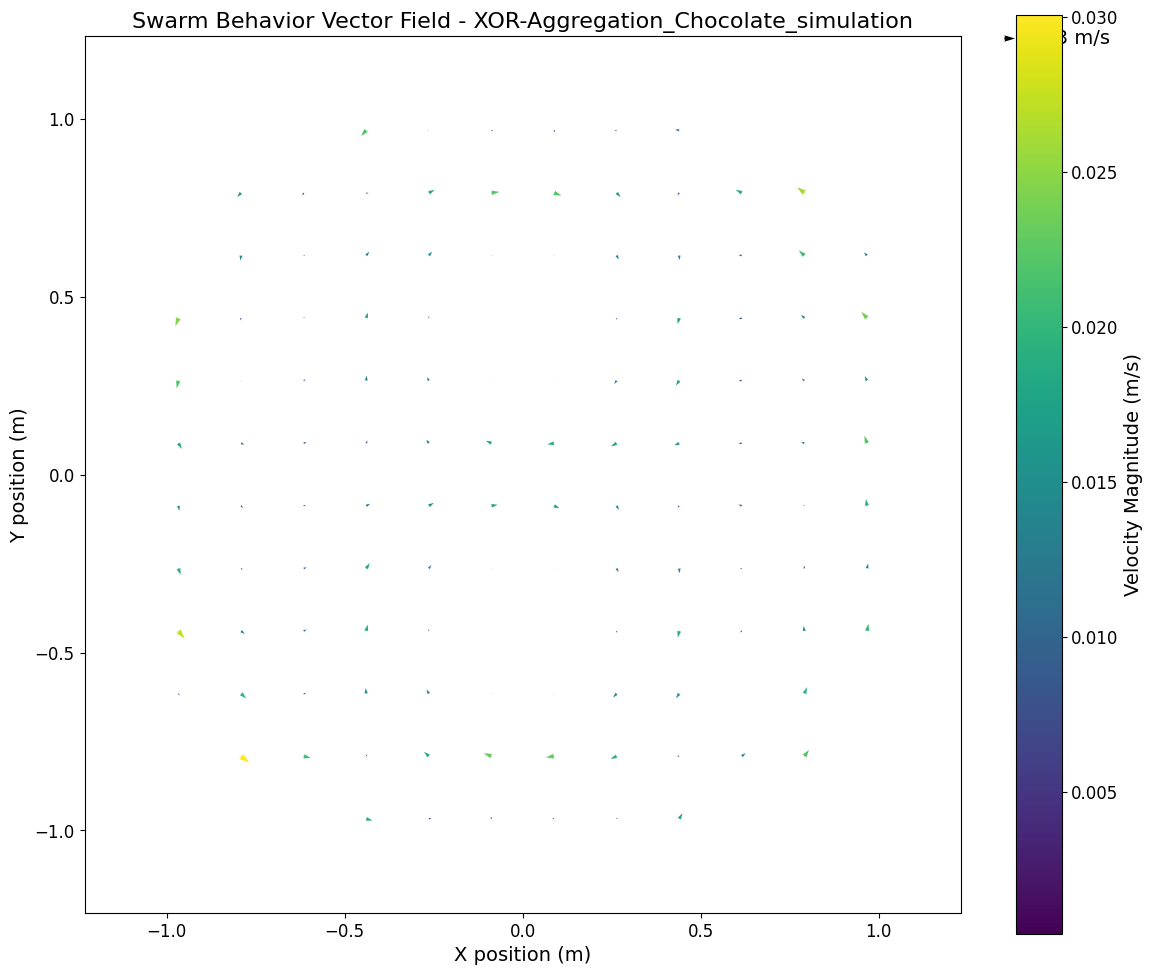

In [2]:
def generate_vector_field(x, y, vx, vy, w):
    """Generates the vector field U using the correct methodology"""
    # Transform coordinates
    x_image = -y + R_ARENA_SIZE/2
    y_image = -x + R_ARENA_SIZE/2
    vx_image = -vy
    vy_image = -vx
    
    # Compute grid dimensions
    nx_bins = int(2 * np.ceil(0.5 * R_ARENA_SIZE / w))
    ny_bins = nx_bins
    
    # Create grid edges
    x_diff = nx_bins * w - R_ARENA_SIZE
    y_diff = ny_bins * w - R_ARENA_SIZE
    x_bins = np.linspace(-x_diff/2, R_ARENA_SIZE + x_diff/2, nx_bins + 1)
    y_bins = np.linspace(-y_diff/2, R_ARENA_SIZE + y_diff/2, ny_bins + 1)
    
    # Discretize positions
    xd = np.digitize(x_image, x_bins) - 1
    yd = np.digitize(y_image, y_bins) - 1
    
    # Initialize accumulation arrays
    M = np.zeros((ny_bins, nx_bins), dtype=np.int32)
    V_sum = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    
    # Compute M_i and velocity sums
    for t in range(vx_image.shape[1]):
        valid = (yd[:, t] >= 0) & (yd[:, t] < ny_bins) & \
                (xd[:, t] >= 0) & (xd[:, t] < nx_bins)
        
        if np.any(valid):
            y_idx = yd[valid, t].astype(int)
            x_idx = xd[valid, t].astype(int)
            
            np.add.at(M, (y_idx, x_idx), 1)
            np.add.at(V_sum, (y_idx, x_idx, 0), vx_image[valid, t])
            np.add.at(V_sum, (y_idx, x_idx, 1), vy_image[valid, t])
    
    # Compute vector field
    mask = M > 0
    U = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        U[mask, 0] = V_sum[mask, 0] / M[mask]
        U[mask, 1] = V_sum[mask, 1] / M[mask]
    
    U = ma.masked_array(U, mask=np.broadcast_to(~mask[..., None], U.shape))
    return U, mask

def generate_mission_vector_field(mission_data, optimal_w):
    """Generates a vector field for all runs in a mission"""
    all_x = np.concatenate([run['x'] for run in mission_data])
    all_y = np.concatenate([run['y'] for run in mission_data])
    all_vx = np.concatenate([run['vx'] for run in mission_data])
    all_vy = np.concatenate([run['vy'] for run in mission_data])
    
    U, mask = generate_vector_field(all_x, all_y, all_vx, all_vy, optimal_w)
    return U, mask

def visualize_vector_field(mission_name, U, mask, R_ARENA_SIZE):
    """Visualizes the vector field for a given mission."""
    ny_bins, nx_bins = U.shape[:2]
    
    # Create grid
    x_edges = np.linspace(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2, nx_bins + 1)
    y_edges = np.linspace(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2, ny_bins + 1)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    # Prepare masked arrays
    Ux = np.ma.masked_array(U[:, :, 0], mask=~mask)
    Uy = np.ma.masked_array(U[:, :, 1], mask=~mask)
    speed = np.sqrt(Ux**2 + Uy**2)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    Q = plt.quiver(X, Y, Ux, Uy, speed, angles='xy', scale_units='xy', scale=1,
                  cmap='viridis', width=0.005, minlength=0)
    
    plt.title(f'Swarm Behavior Vector Field - {mission_name}', fontsize=16)
    plt.xlabel('X position (m)', fontsize=14)
    plt.ylabel('Y position (m)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2)
    plt.ylim(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Add colorbar
    cbar = plt.colorbar(Q)
    cbar.set_label('Velocity Magnitude (m/s)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Add reference arrow
    max_speed = speed.max()
    plt.quiverkey(Q, 0.85, 0.95, max_speed, f'{max_speed:.2f} m/s',
                  labelpos='E', coordinates='figure', fontproperties={'size': 14})
    
    plt.tight_layout()
    plt.savefig(f'swarm_field_{mission_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# For Jupyter notebook usage:
def analyze_missions(best_fsms, all_mission_data, optimal_w_normalized):
    """Analyze all missions and generate vector fields"""
    # Generate vector fields for each mission
    mission_vector_fields = {}
    for mission, data in tqdm(zip(best_fsms.index, all_mission_data), 
                            total=len(best_fsms), 
                            desc="Generating mission vector fields"):
        U, mask = generate_mission_vector_field(data, optimal_w_normalized)
        mission_vector_fields[mission] = (U, mask)
    
    # Display basic information about the vector fields
    for mission, (U, mask) in mission_vector_fields.items():
        print(f"\nMission: {mission}")
        print(f"Vector field shape: {U.shape}")
        print(f"Number of occupied cells: {np.sum(mask)}")
        print(f"Mean velocity magnitude: {np.mean(np.linalg.norm(U, axis=2)[mask]):.4f}")
    
    # Visualize each vector field
    for mission, (U, mask) in mission_vector_fields.items():
        visualize_vector_field(mission, U, mask, R_ARENA_SIZE)
    
    return mission_vector_fields

# First cell: Import and data loading
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  

# Generate and visualize vector fields
mission_vector_fields = analyze_missions(best_fsms, all_mission_data, optimal_bin_widths)

In [3]:
#!/usr/bin/env python3

import os
import sys
import warnings
import re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import skfda as sf
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda.misc.operators import SRSF
from functools import partial
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from time import time
from scipy.ndimage import convolve
from gudhi import AlphaComplex, SimplexTree
from gudhi.representations import Silhouette
from pynhhd import nHHD

# ----------------------------
# Monkey Patch for Deprecated np.float
# ----------------------------
import pynhhd.poisson
import pynhhd.nHHD

# Replace np.float with float globally within pynhhd.poisson
pynhhd.poisson.np.float = float  # or np.float64

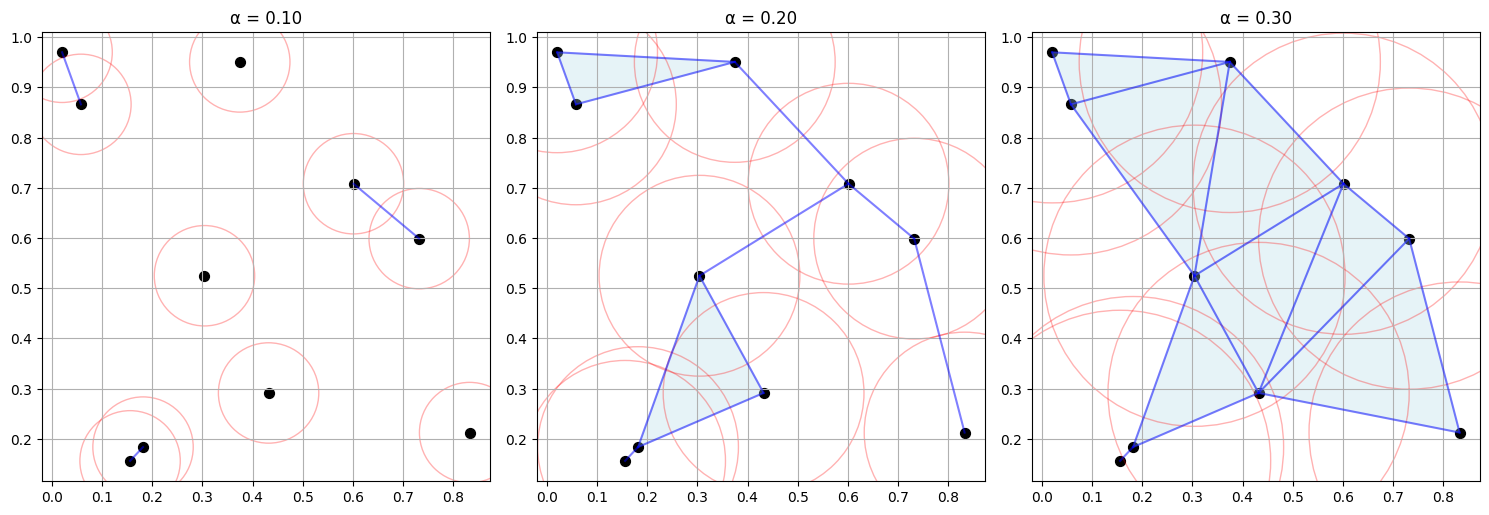

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import AlphaComplex
from scipy.spatial import Delaunay

def demonstrate_alpha_complex_construction(points, alpha_values):
    """
    Demonstrate the construction of alpha complex for different alpha values.
    
    Args:
        points: Array of 2D points
        alpha_values: List of alpha values to demonstrate
    """
    # Create alpha complex
    alpha_complex = AlphaComplex(points=points)
    
    # Create visualization
    fig, axes = plt.subplots(1, len(alpha_values), figsize=(5*len(alpha_values), 5))
    if len(alpha_values) == 1:
        axes = [axes]
    
    # Get Delaunay triangulation (maximum alpha complex)
    tri = Delaunay(points)
    
    for idx, alpha in enumerate(alpha_values):
        ax = axes[idx]
        
        # Create simplex tree with current alpha value
        st = alpha_complex.create_simplex_tree()
        
        # Plot points
        ax.scatter(points[:, 0], points[:, 1], c='black', s=50)
        
        # Plot simplices
        for simplex, alpha_square in st.get_filtration():
            if alpha_square <= alpha**2:  # Alpha complex uses squared distances
                if len(simplex) == 2:  # Edge
                    edge_points = points[simplex]
                    ax.plot(edge_points[:, 0], edge_points[:, 1], 'b-', alpha=0.5)
                elif len(simplex) == 3:  # Triangle
                    tri_points = points[simplex]
                    ax.fill(tri_points[:, 0], tri_points[:, 1], 
                           color='lightblue', alpha=0.3)
        
        # Draw alpha balls
        for point in points:
            circle = plt.Circle(point, alpha, fill=False, color='red', alpha=0.3)
            ax.add_artist(circle)
        
        ax.set_title(f'α = {alpha:.2f}')
        ax.set_aspect('equal')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Generate sample points
    np.random.seed(42)
    points = np.random.rand(10, 2)
    
    # Demonstrate alpha complex construction
    demonstrate_alpha_complex_construction(points, [0.1, 0.2, 0.3])

/tmp/ipykernel_16861/2014431941.py:141: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()



Persistence Statistics:
Number of filtration values in range [0.0103, 1.0305]: 178
Number of H0 features (components): 70
Number of H1 features (holes): 51


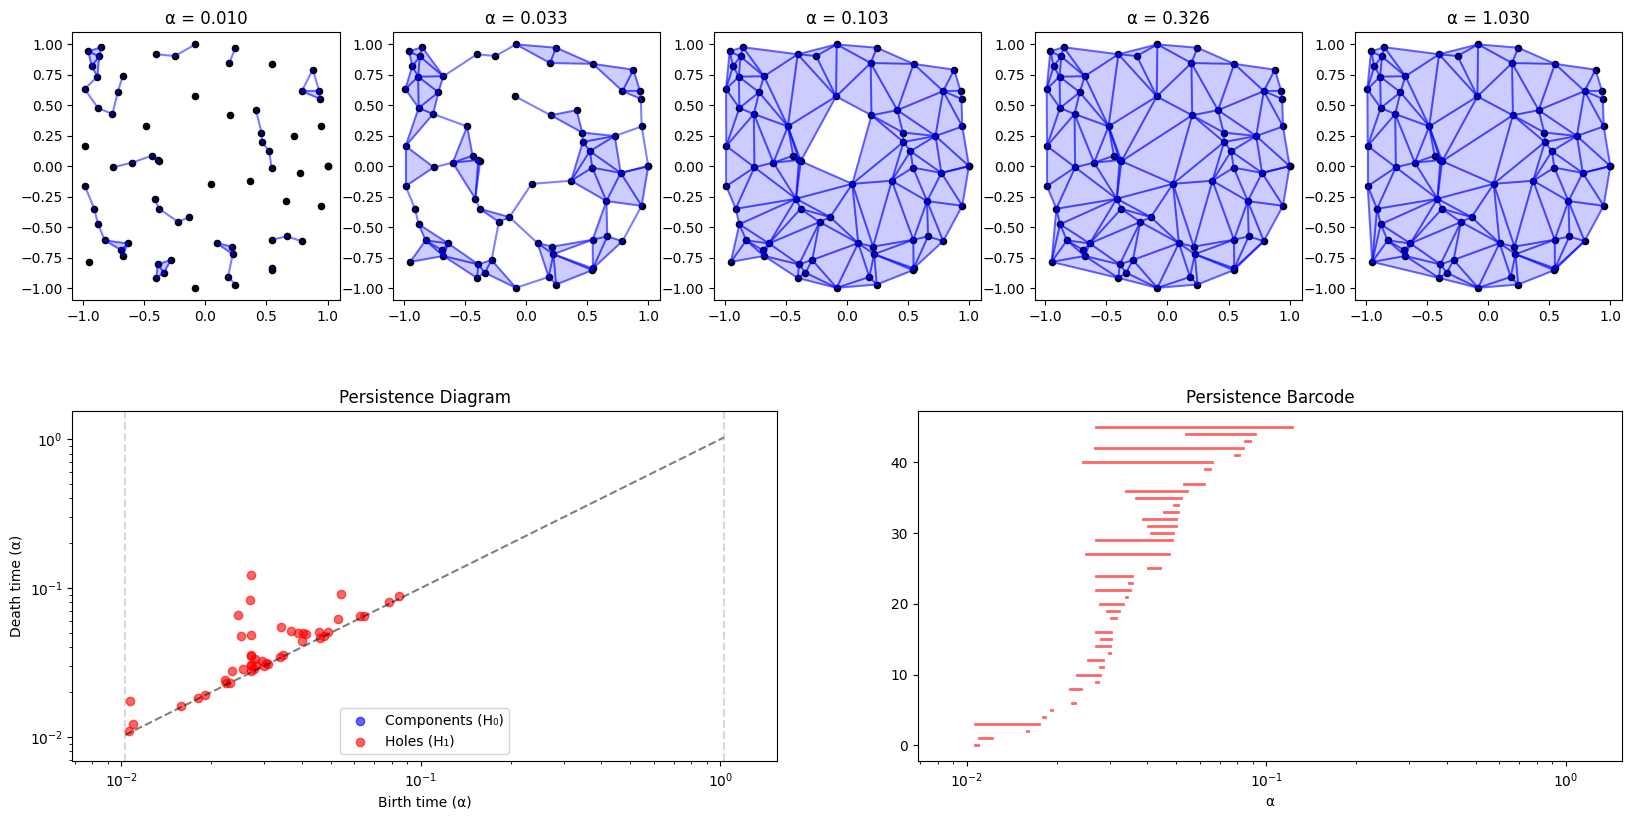

In [5]:
def explain_persistence_diagram(points, alpha_range=None):
    """
    Explains persistence diagrams by visualizing the process step by step.
    
    Parameters:
    points: numpy array of shape (n, 2) containing 2D points
    alpha_range: tuple of (min_alpha, max_alpha) or None
    """
    # Create Alpha Complex
    alpha_complex = AlphaComplex(points)
    
    # Get the filtration values
    st = alpha_complex.create_simplex_tree()
    filtration_values = sorted(list(set([simplex[1] for simplex in st.get_filtration()])))
    
    # Set alpha range if not provided
    if alpha_range is None:
        min_alpha = min(filtration_values) if filtration_values else 0
        max_alpha = max(filtration_values) if filtration_values else 1
    else:
        min_alpha, max_alpha = alpha_range
    
    # Filter filtration values to be within our range
    filtration_values = [a for a in filtration_values if min_alpha <= a <= max_alpha]
    
    if not filtration_values:
        raise ValueError("No filtration values in the specified range")
    
    # Compute persistence
    st.persistence()
    
    # Get persistence pairs for dimensions 0 and 1
    pairs_0 = st.persistence_intervals_in_dimension(0)
    pairs_1 = st.persistence_intervals_in_dimension(1)
    
    # Create visualization
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Show point cloud and growing alpha complex
    n_steps = 5
    alphas = np.geomspace(min_alpha, max_alpha, n_steps)
    
    for i, alpha in enumerate(alphas):
        ax = fig.add_subplot(2, n_steps, i+1)
        
        # Plot points
        ax.scatter(points[:, 0], points[:, 1], c='black', s=20)
        
        # Create and plot alpha complex at current alpha
        st_current = alpha_complex.create_simplex_tree(alpha)
        
        # Plot edges
        for simplex in st_current.get_skeleton(1):
            if len(simplex[0]) == 2:
                v1, v2 = simplex[0]
                ax.plot([points[v1,0], points[v2,0]], 
                       [points[v1,1], points[v2,1]], 
                       'b-', alpha=0.5)
        
        # Plot triangles
        for simplex in st_current.get_skeleton(2):
            if len(simplex[0]) == 3:
                v1, v2, v3 = simplex[0]
                triangle = plt.Polygon(points[[v1,v2,v3]], 
                                    alpha=0.2, 
                                    color='blue')
                ax.add_patch(triangle)
        
        ax.set_title(f'α = {alpha:.3f}')
        ax.set_aspect('equal')
    
    # 2. Show persistence diagram and barcode
    ax_diag = fig.add_subplot(2, 2, 3)
    
    # Plot points from dimension 0 (components)
    if len(pairs_0) > 0:
        births_0 = pairs_0[:, 0]
        deaths_0 = pairs_0[:, 1]
        # Only plot points within our alpha range
        mask_0 = (births_0 >= min_alpha) & ((deaths_0 <= max_alpha) | (deaths_0 == np.inf))
        births_0 = births_0[mask_0]
        deaths_0 = deaths_0[mask_0]
        deaths_0[deaths_0 == np.inf] = max_alpha * 1.5
        ax_diag.scatter(births_0, deaths_0, 
                       c='blue', label='Components (H₀)', 
                       alpha=0.6)
    
    # Plot points from dimension 1 (holes)
    if len(pairs_1) > 0:
        births_1 = pairs_1[:, 0]
        deaths_1 = pairs_1[:, 1]
        # Only plot points within our alpha range
        mask_1 = (births_1 >= min_alpha) & (deaths_1 <= max_alpha)
        births_1 = births_1[mask_1]
        deaths_1 = deaths_1[mask_1]
        ax_diag.scatter(births_1, deaths_1, 
                       c='red', label='Holes (H₁)', 
                       alpha=0.6)
    
    # Add diagonal line
    ax_diag.plot([min_alpha, max_alpha], [min_alpha, max_alpha], 'k--', alpha=0.5)
    
    # Add vertical lines for min and max alpha
    ax_diag.axvline(x=min_alpha, color='gray', linestyle='--', alpha=0.3)
    ax_diag.axvline(x=max_alpha, color='gray', linestyle='--', alpha=0.3)
    
    ax_diag.set_xlabel('Birth time (α)')
    ax_diag.set_ylabel('Death time (α)')
    ax_diag.set_title('Persistence Diagram')
    ax_diag.legend()
    ax_diag.set_xscale('log')
    ax_diag.set_yscale('log')
    ax_diag.set_xlim(min_alpha/1.5, max_alpha*1.5)
    ax_diag.set_ylim(min_alpha/1.5, max_alpha*1.5)
    
    # Barcode diagram
    ax_barcode = fig.add_subplot(2, 2, 4)
    
    # Plot bars for dimension 0
    current_y = 0
    for birth, death in pairs_0:
        if birth >= min_alpha and (death <= max_alpha or death == np.inf):
            if death == np.inf:
                death = max_alpha * 1.5
            ax_barcode.plot([birth, death], [current_y, current_y], 
                           'b-', linewidth=2, alpha=0.6)
            current_y += 1
    
    # Plot bars for dimension 1
    for birth, death in pairs_1:
        if birth >= min_alpha and death <= max_alpha:
            ax_barcode.plot([birth, death], [current_y, current_y], 
                           'r-', linewidth=2, alpha=0.6)
            current_y += 1
    
    ax_barcode.set_xlabel('α')
    ax_barcode.set_title('Persistence Barcode')
    ax_barcode.set_xscale('log')
    ax_barcode.set_xlim(min_alpha/1.5, max_alpha*1.5)
    
    plt.tight_layout()
    
    return pairs_0, pairs_1, filtration_values

# Example usage with specific alpha range
dx = 0.2061  # Your optimal bin width
alpha_range = (dx/20, dx*5)

# Create example points
np.random.seed(42)
n_points = 50
random_points = np.random.rand(n_points, 2) * 2 - 1

# Create a circle of points with a hole
theta = np.linspace(0, 2*np.pi, 20)
circle_points = np.column_stack([np.cos(theta), np.sin(theta)])
all_points = np.vstack([random_points, circle_points])

# Compute persistence with specific alpha range
pairs_0, pairs_1, filtration = explain_persistence_diagram(all_points, alpha_range)

# Print some statistics about the persistence computation
print("\nPersistence Statistics:")
print(f"Number of filtration values in range [{alpha_range[0]:.4f}, {alpha_range[1]:.4f}]:", len(filtration))
print("Number of H0 features (components):", len(pairs_0))
print("Number of H1 features (holes):", len(pairs_1))

In [6]:
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pynhhd import nHHD
import numpy as np
import numpy.ma as ma
from tqdm import tqdm
#!/usr/bin/env python3

import os
import sys
import warnings
import re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import skfda as sf
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda.misc.operators import SRSF
from functools import partial
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from time import time
from scipy.ndimage import convolve
from gudhi import AlphaComplex, SimplexTree
from gudhi.representations import Silhouette
from pynhhd import nHHD

# ----------------------------
# Monkey Patch for Deprecated np.float
# ----------------------------
import pynhhd.poisson
import pynhhd.nHHD

# Replace np.float with float globally within pynhhd.poisson
pynhhd.poisson.np.float = float  # or np.float64
def plot_hhd_contours(mission, field, dx, mask):
    """
    Performs Natural Helmholtz-Hodge Decomposition on the vector field and plots the divergent
    and rotational components. Returns the components for reuse.

    Parameters:
    - mission: str, name of the mission
    - field: 3D numpy array, vector field (ny_bins x nx_bins x 2)
    - dx: tuple, grid spacings in x and y directions
    - mask: 2D numpy array, boolean mask indicating occupied cells

    Returns:
    - nD: 2D numpy array, divergent component
    - nRu: 2D numpy array, rotational component
    """
    ny_bins, nx_bins = field.shape[:2]

    # Initialize nHHD
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=dx)

    # Prepare the vector field for decomposition
    # Create the masked array directly from the field
    masked_field = ma.array(field, mask=np.dstack((~mask, ~mask)))
    nhhd.decompose(masked_field)

    # Extract components
    nD = nhhd.nD  # Divergent component
    nRu = nhhd.nRu  # Rotational component

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f"Natural Helmholtz-Hodge Decomposition - {mission}", fontsize=16)

    components = [
        ("D* (Divergent)", nD),
        ("R* (Rotational)", -nRu)
    ]

    x = np.linspace(0, nx_bins - 1, nx_bins)
    y = np.linspace(0, ny_bins - 1, ny_bins)
    X, Y = np.meshgrid(x, y)

    for ax, (title, component) in zip(axes, components):
        contour = ax.contourf(X, Y, component, levels=20, cmap='RdBu')
        ax.contour(X, Y, component, levels=20, colors='k', linewidths=0.5, alpha=0.3)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_aspect('equal')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(contour, cax=cax)

    plt.tight_layout()
    plt.savefig(f'hhd_contours_{mission}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return nD, nRu

def analyze_missions(best_fsms, all_mission_data, mission_vector_fields, optimal_w_normalized):
    """
    Analyzes all missions by performing nHHD decomposition on preloaded vector fields.
    Stores and returns the divergent and rotational components for each mission.

    Parameters:
    - best_fsms: pandas DataFrame, containing best FSMs per mission
    - all_mission_data: list of mission data (loaded from joblib)
    - mission_vector_fields: dict, loaded vector fields per mission
    - optimal_w_normalized: float, the optimal normalized bin width

    Returns:
    - mission_vector_fields: dict, updated with vector fields (unchanged)
    - mission_hhd_components: dict, containing nD and nRu per mission
    """
    mission_hhd_components = {}

    # Iterate over each mission and perform decomposition
    for mission, data in tqdm(zip(best_fsms.index, all_mission_data),
                              total=len(best_fsms),
                              desc="Performing nHHD Decomposition"):
        # Retrieve the preloaded vector field and mask
        U, mask = mission_vector_fields.get(mission, (None, None))

        if U is None or mask is None:
            print(f"Warning: Vector field or mask for mission '{mission}' not found. Skipping.")
            continue

        # Perform nHHD decomposition and plot contours
        nD, nRu = plot_hhd_contours(mission, U, (optimal_w_normalized, optimal_w_normalized), mask)
        mission_hhd_components[mission] = {'nD': nD, 'nRu': nRu}

        # Display basic information about the vector field
        print(f"\nMission: {mission}")
        print(f"Vector field shape: {U.shape}")
        print(f"Number of occupied cells: {np.sum(mask)}")
        print(f"Mean velocity magnitude: {np.mean(np.linalg.norm(U, axis=2)[mask]):.4f}")

    # Save the HHD components for reuse
    hhd_components_path = 'mission_hhd_components.joblib'
    joblib.dump(mission_hhd_components, hhd_components_path)
    print(f"\nSaved mission_hhd_components to {hhd_components_path}")

    return mission_vector_fields, mission_hhd_components


Performing nHHD Decomposition:   0%|          | 0/5 [00:00<?, ?it/s]

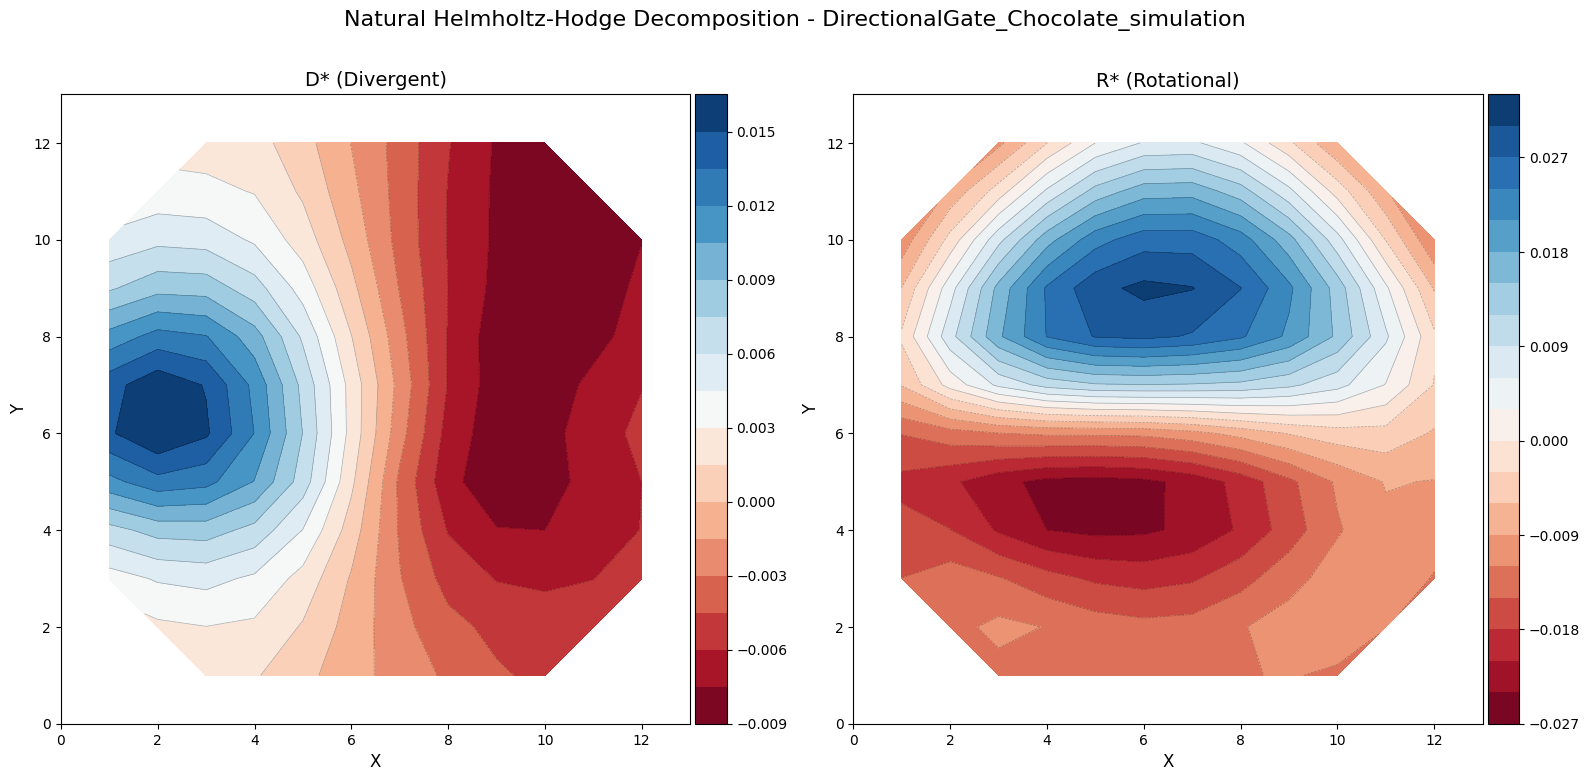

Performing nHHD Decomposition:  20%|██        | 1/5 [00:00<00:02,  1.42it/s]


Mission: DirectionalGate_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 132
Mean velocity magnitude: 0.0525


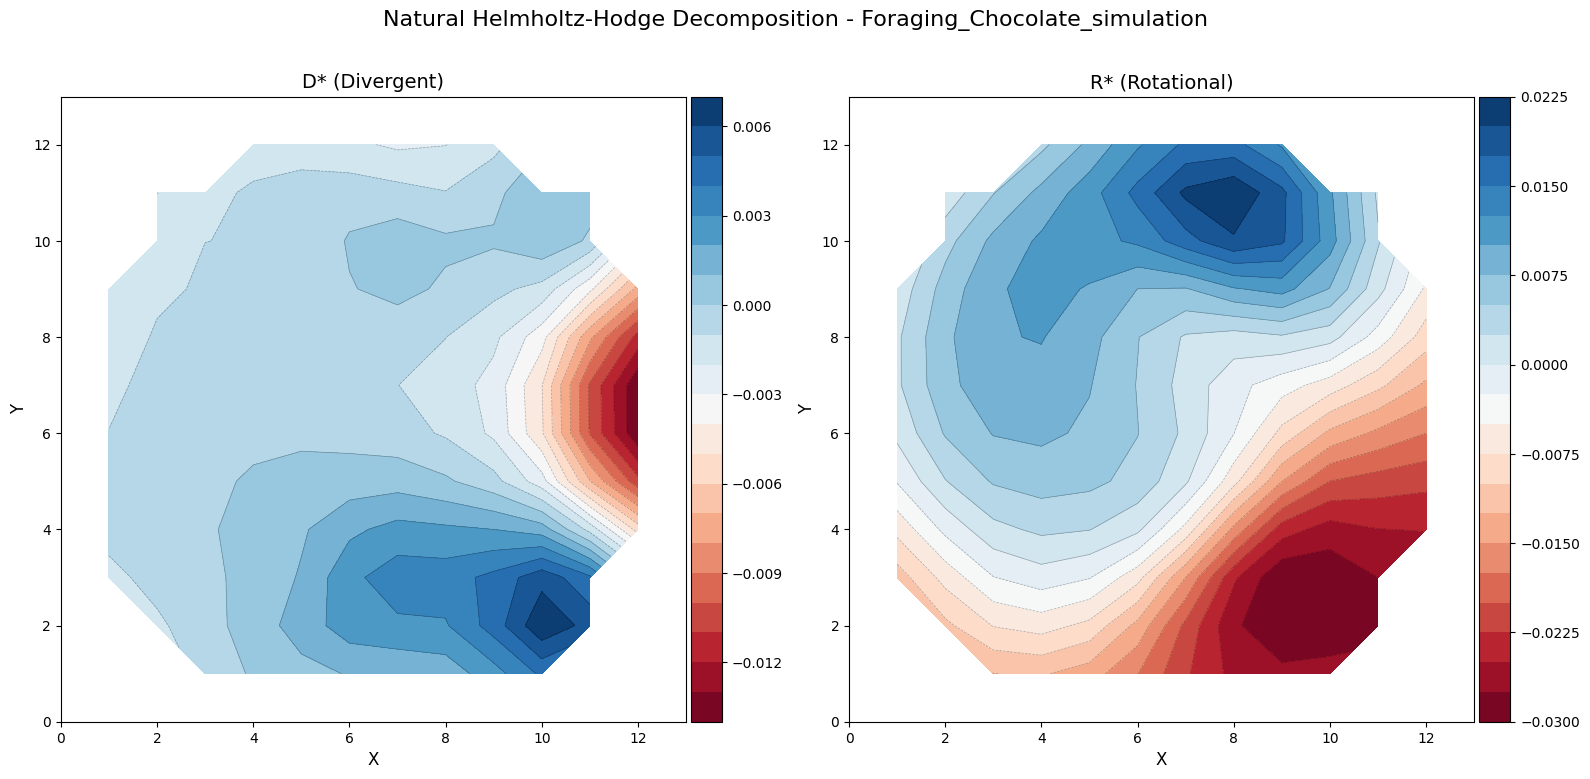

Performing nHHD Decomposition:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]


Mission: Foraging_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 127
Mean velocity magnitude: 0.0349


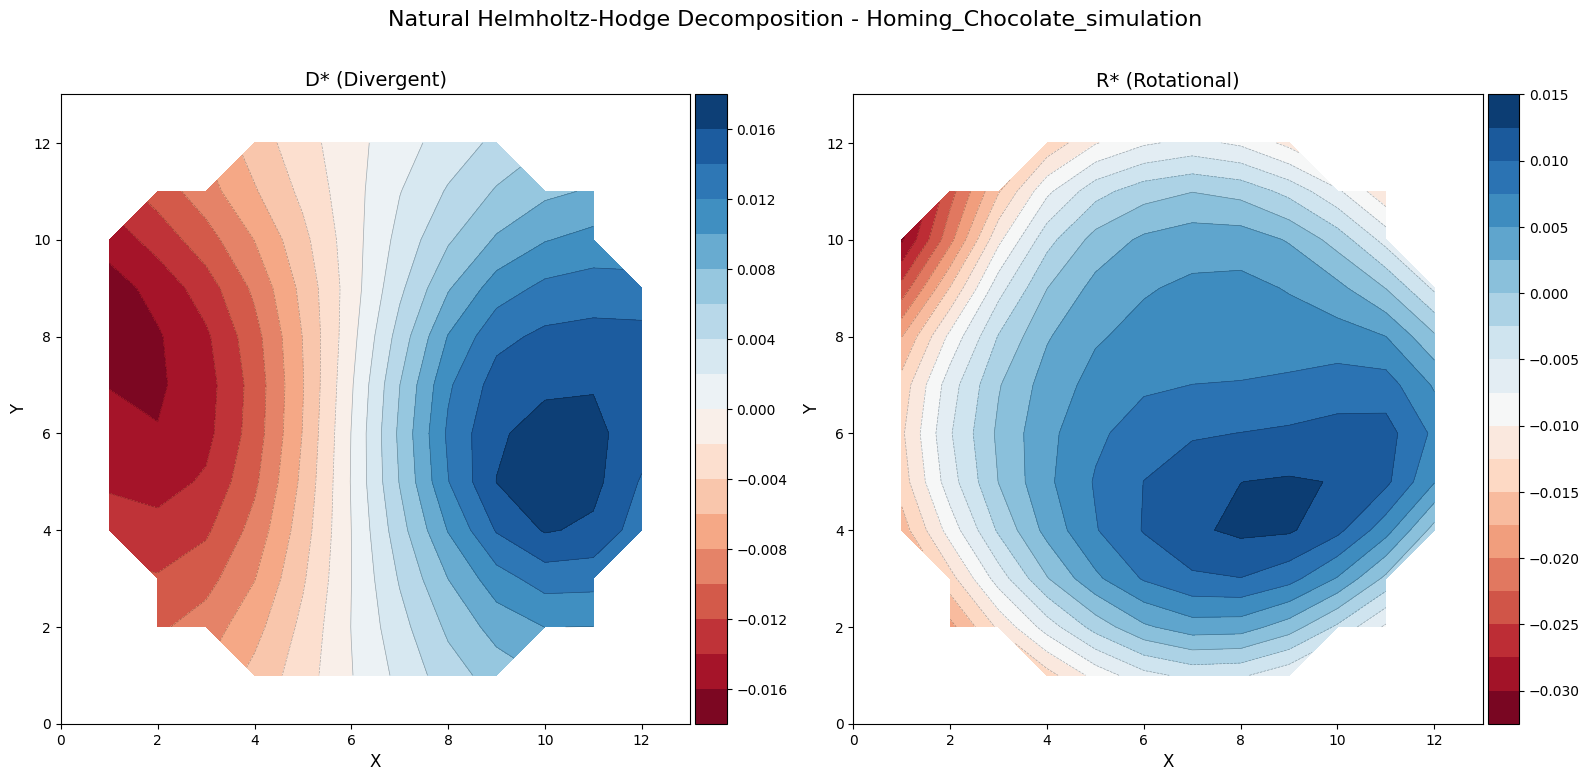

Performing nHHD Decomposition:  60%|██████    | 3/5 [00:02<00:01,  1.42it/s]


Mission: Homing_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 125
Mean velocity magnitude: 0.0339


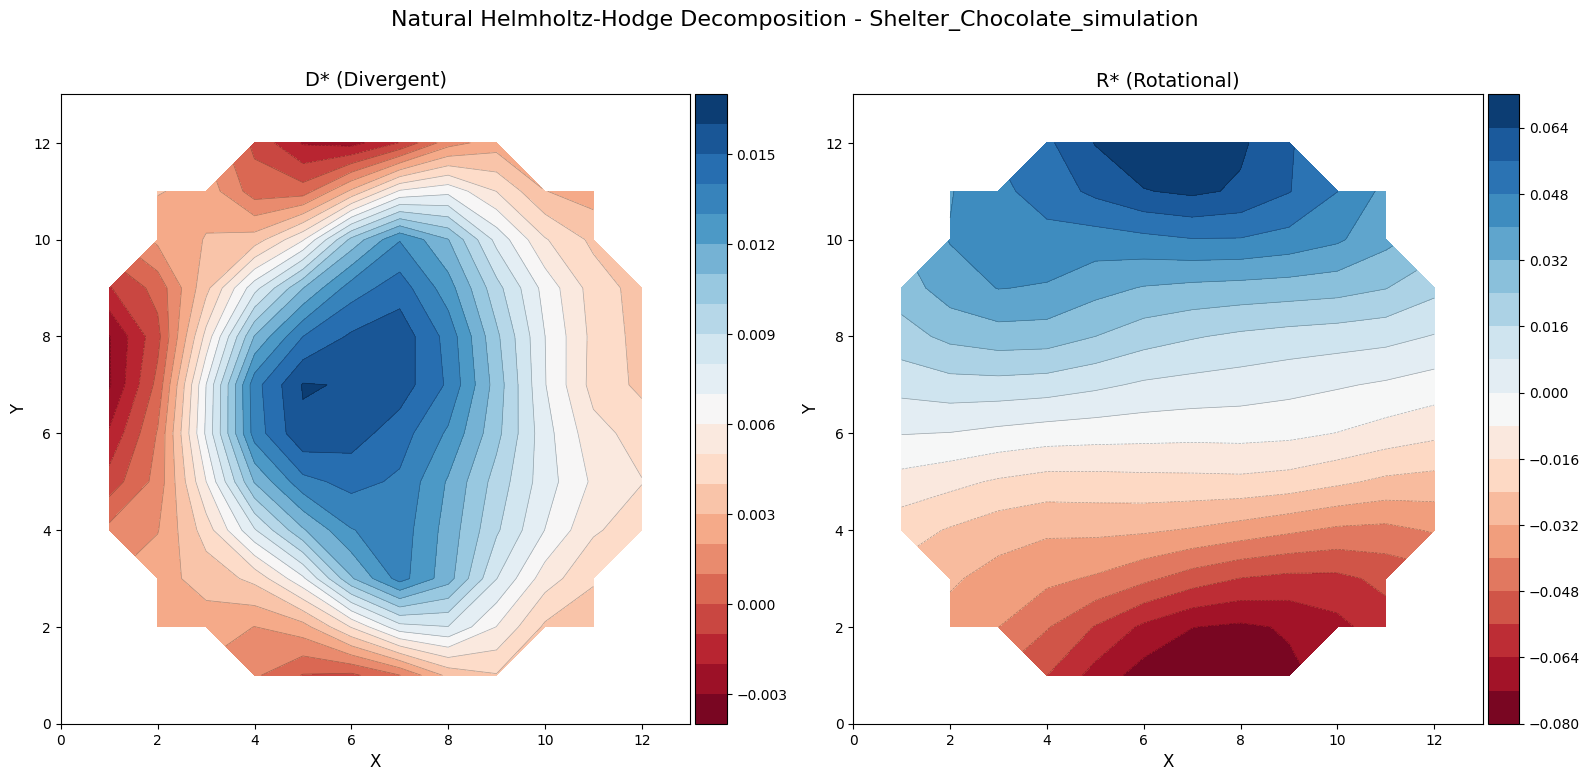

Performing nHHD Decomposition:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]


Mission: Shelter_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 124
Mean velocity magnitude: 0.0399


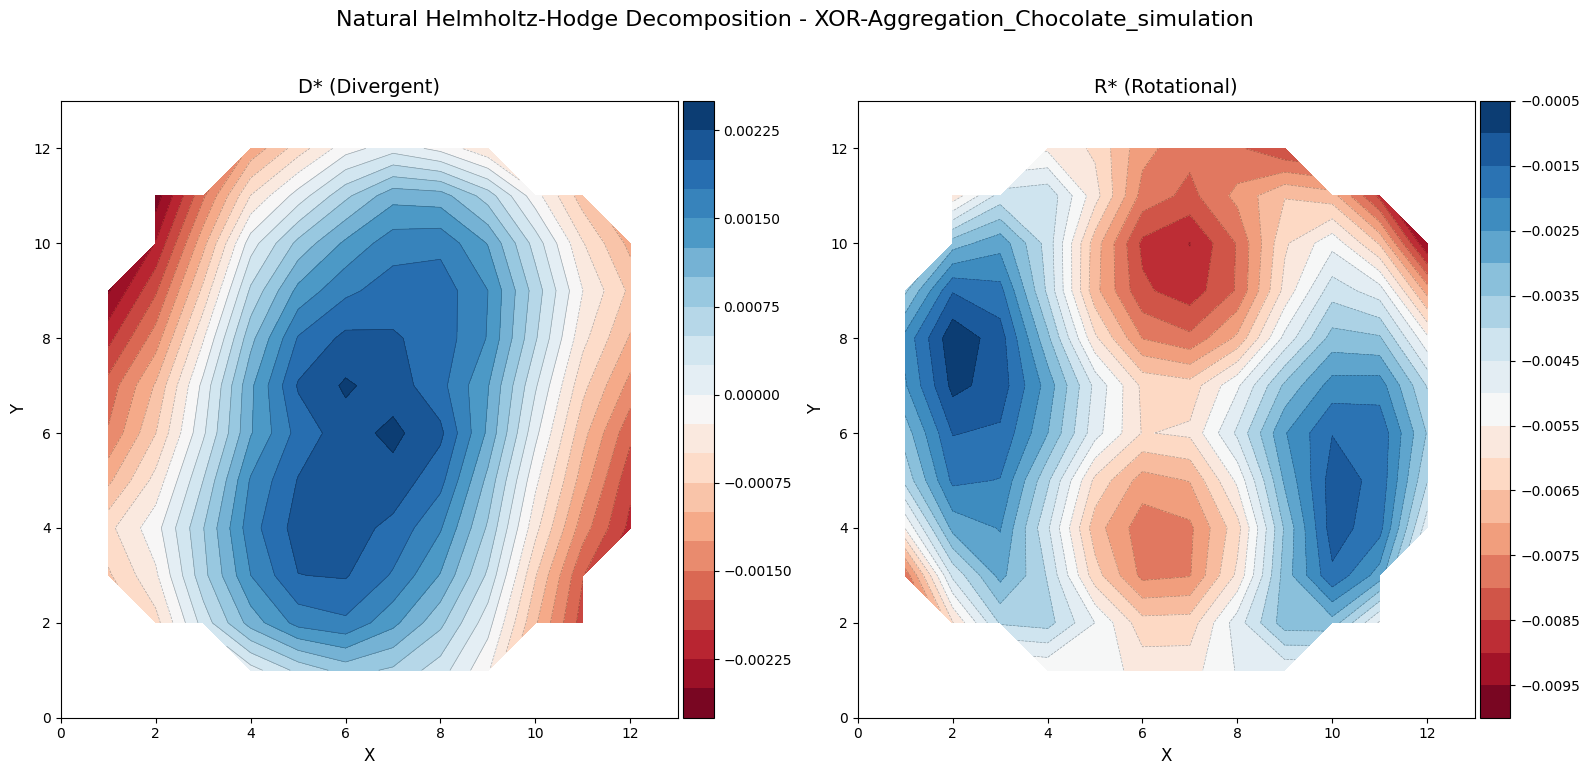

Performing nHHD Decomposition: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Mission: XOR-Aggregation_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 126
Mean velocity magnitude: 0.0121

Saved mission_hhd_components to mission_hhd_components.joblib


In [7]:
mission_vector_fields, mission_hhd_components = analyze_missions(
    best_fsms=best_fsms,
    all_mission_data=all_mission_data,
    mission_vector_fields=mission_vector_fields,
    optimal_w_normalized=optimal_bin_widths
)

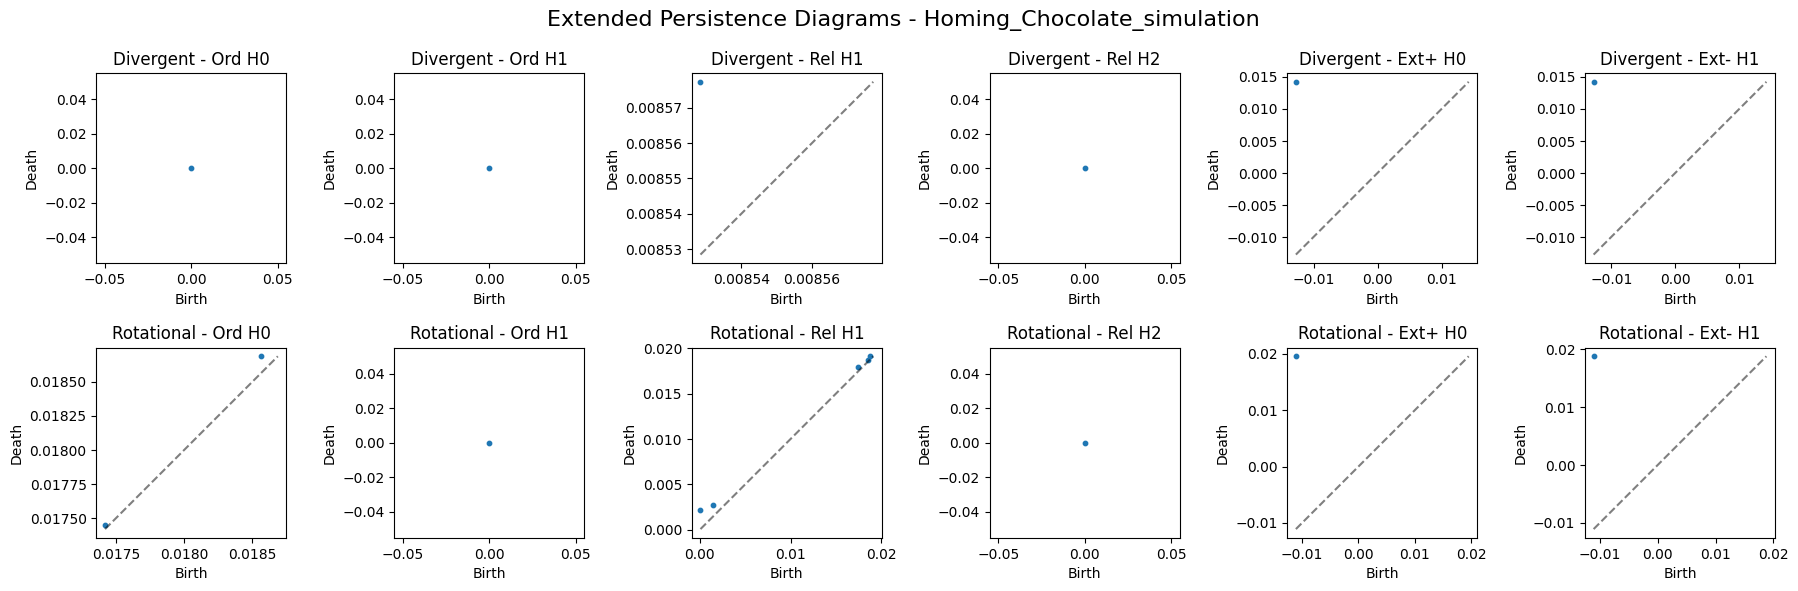

First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


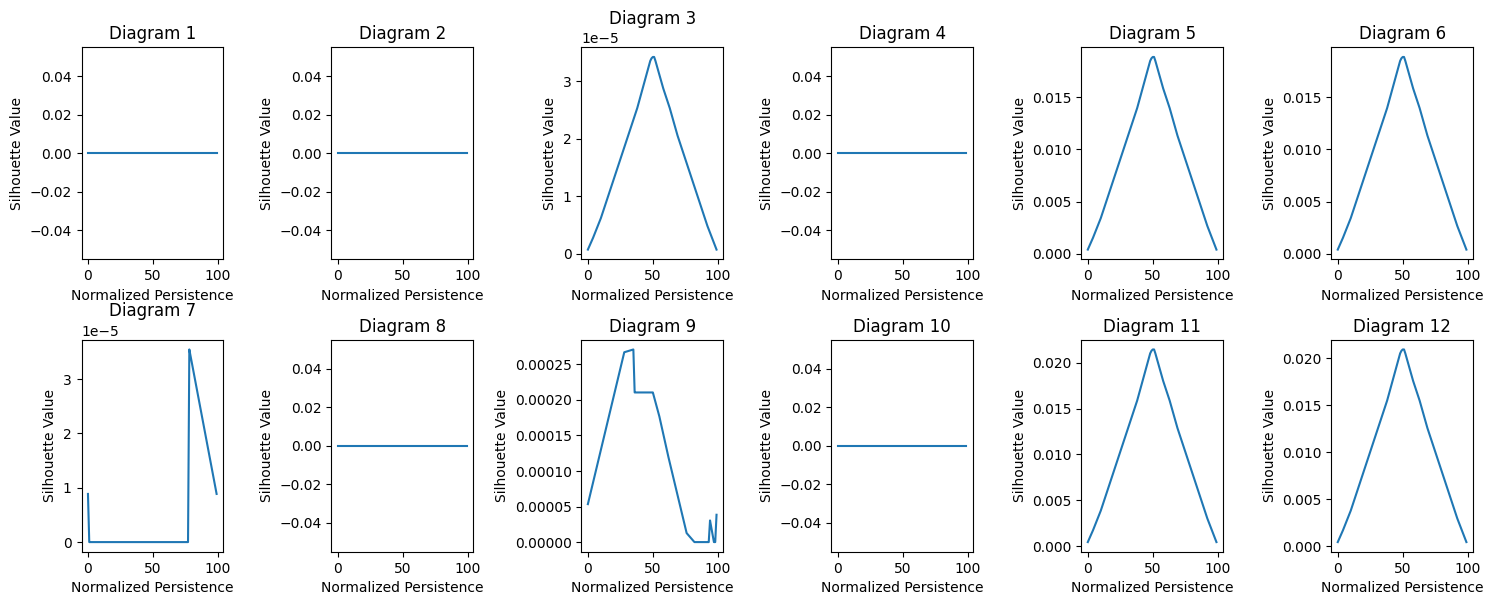

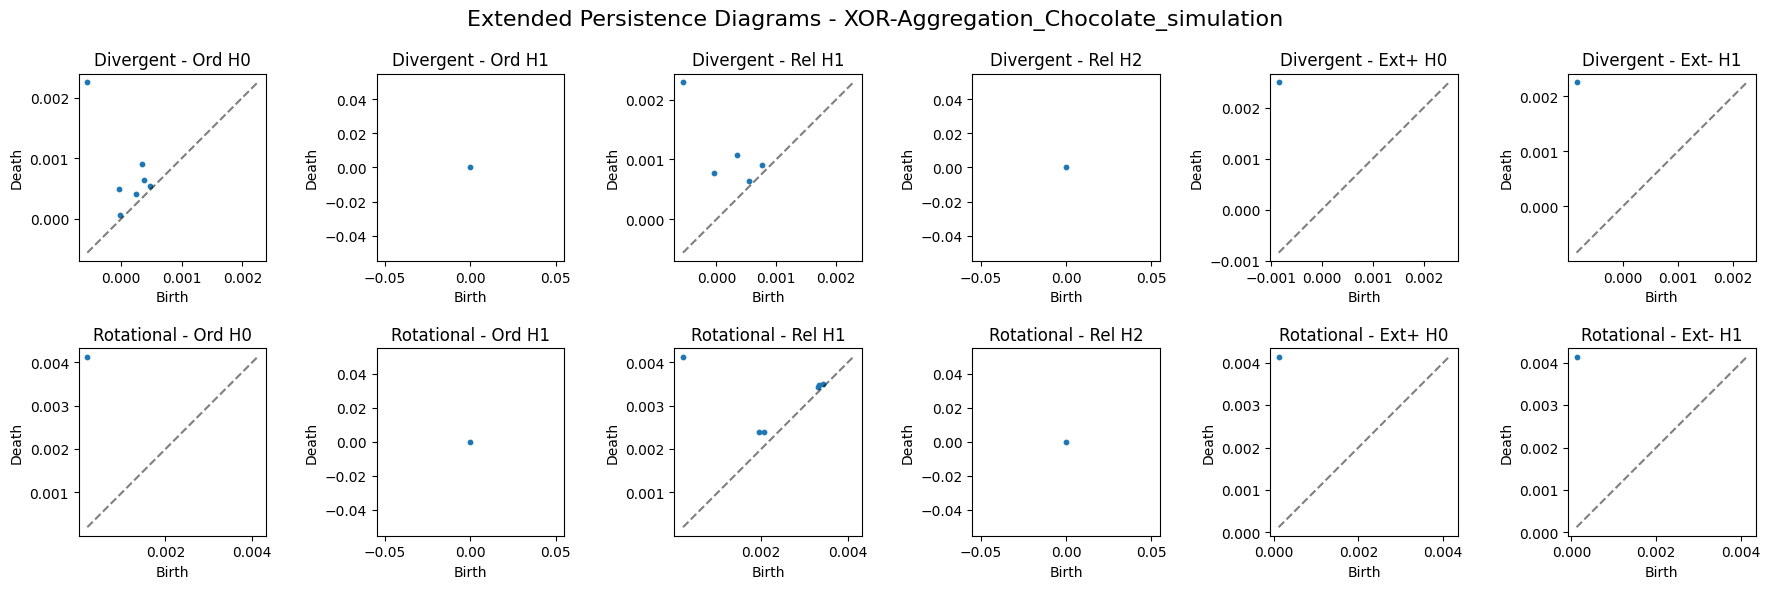

First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


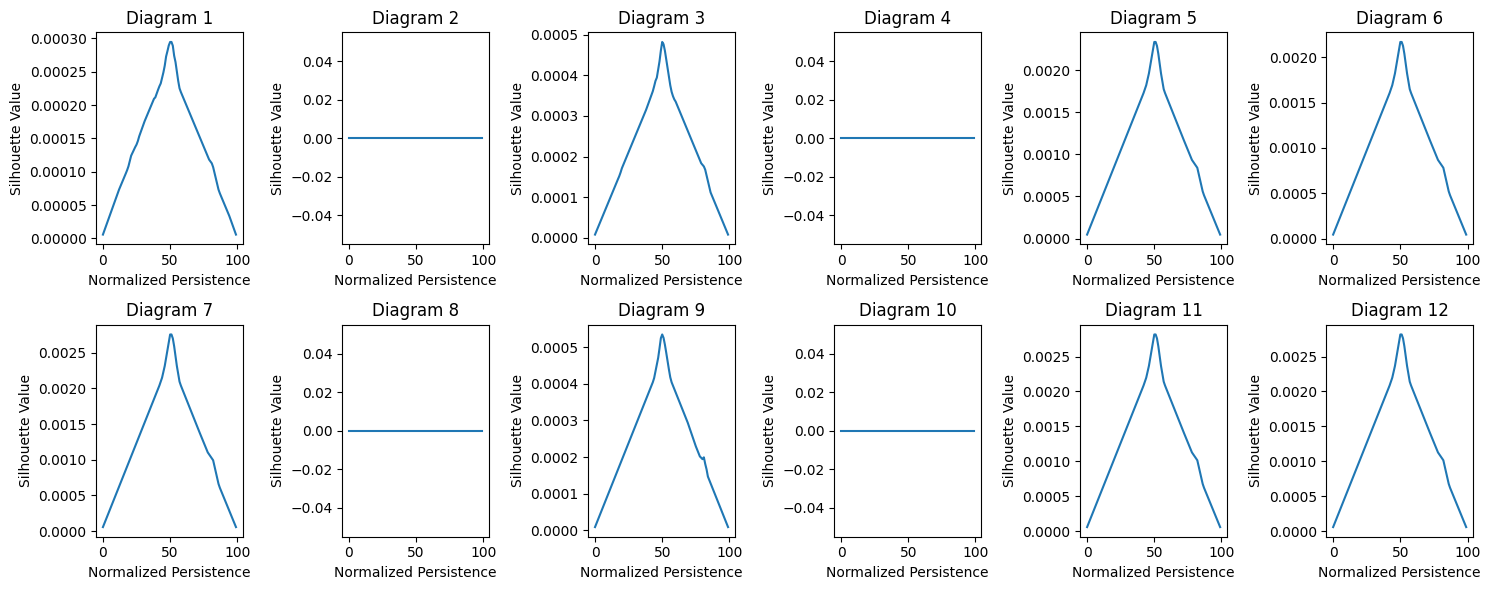

Mean L2 distance between aligned silhouettes of Homing_Chocolate_simulation and XOR-Aggregation_Chocolate_simulation: 0.03534365285558288


In [9]:
#!/usr/bin/env python3

# Compute persistence diagrams and align silhouettes using the Fisher-Rao metric

import sys
import warnings
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import skfda as sf
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from multiprocessing import Pool
from pynhhd import nHHD
from gudhi import AlphaComplex
from gudhi.representations import Silhouette


def createSimplexTree(x, mask=None):
    """Encode masked 2D array as simplex tree."""
    # Ensure the input is a masked array
    if mask is not None:
        if not ma.isMaskedArray(x):
            x = ma.masked_where(~mask, x)
        else:
            x = ma.masked_where(~mask, x)
    else:
        if not ma.isMaskedArray(x):
            x = ma.masked_array(x, mask=x == 0)
        else:
            x = ma.masked_where(x == 0, x)

    m = x.mask
    if isinstance(m, np.bool_):
        m = np.full(x.shape, m)

    r, c = np.nonzero(~m)
    points = []
    filtration_values = []
    for ri, ci in zip(r, c):
        points.append([ci, -ri])  # Note the swapping of axes to match the coordinate system
        filtration_values.append(float(x[ri, ci]))

    # Create Alpha Complex and simplex tree
    ax = AlphaComplex(points=points)
    st = ax.create_simplex_tree(0.5)
    st.reset_filtration(-1e8)

    # Assign filtration values to vertices
    for idx, filtration in enumerate(filtration_values):
        st.assign_filtration([idx], filtration)
    st.make_filtration_non_decreasing()

    return st


def extendedPersistence(field, dx, mask):
    """Extended persistence for a masked vector field with separation dx."""
    def _pd2ndarr(dgm, dim):
        """Extracts PD of dimension dim from dgm into ndarray."""
        x = np.copy(np.atleast_2d(np.asarray([p[1] for p in dgm if p[0] == dim])))
        if x.size == 0:
            x = np.array([[0., 0.]])
        return x

    # Decompose field
    ny_bins, nx_bins = field.shape[:2]
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=dx)
    field_decompose = field.copy()
    field_decompose[~mask] = 0.0  # Set masked areas to zero
    nhhd.decompose(field_decompose)

    # Extended persistence pairs of natural potentials
    dgms = []
    for x in [nhhd.nD, -nhhd.nRu]:
        x_masked = ma.array(x, mask=mask)
        st = createSimplexTree(x_masked)
        st.extend_filtration()
        x_dgms = st.extended_persistence()

        dgms.extend([
            _pd2ndarr(x_dgms[0], 0),  # Ord H0
            _pd2ndarr(x_dgms[0], 1),  # Ord H1
            np.roll(_pd2ndarr(x_dgms[1], 1), 1, axis=1),  # Rel H1
            np.roll(_pd2ndarr(x_dgms[1], 2), 1, axis=1),  # Rel H2
            _pd2ndarr(x_dgms[2], 0),  # Ext+ H0
            np.roll(_pd2ndarr(x_dgms[3], 1), 1, axis=1)   # Ext- H1
        ])

    return dgms


def plot_persistence_diagrams(mission, dgms):
    """Plot persistence diagrams for the computed extended persistence diagrams."""
    titles = ['Ord H0', 'Ord H1', 'Rel H1', 'Rel H2', 'Ext+ H0', 'Ext- H1']
    components = ['Divergent', 'Rotational']
    num_diagrams = len(dgms) // 2  # Since we have two components

    fig, axes = plt.subplots(2, num_diagrams, figsize=(18, 6))
    for i in range(2):  # For Divergent and Rotational components
        for j in range(num_diagrams):
            idx = i * num_diagrams + j
            ax = axes[i, j]
            dgm = dgms[idx]
            if dgm.size > 0:
                ax.scatter(dgm[:, 0], dgm[:, 1], s=10)
                ax.plot([dgm[:, 0].min(), dgm[:, 1].max()],
                        [dgm[:, 0].min(), dgm[:, 1].max()], 'k--', alpha=0.5)
            else:
                ax.text(0.5, 0.5, 'No points', ha='center', va='center')
            ax.set_title(f'{components[i]} - {titles[j]}')
            ax.set_xlabel('Birth')
            ax.set_ylabel('Death')
            ax.set_aspect('equal')
    fig.suptitle(f'Extended Persistence Diagrams - {mission}', fontsize=16)
    plt.tight_layout()
    plt.show()


def compute_silhouette(dgms):
    """Compute the silhouettes for the persistence diagrams."""
    silhouettes = []
    for dgm in dgms:
        if len(dgm) > 0:
            sil = Silhouette(resolution=100).fit_transform([dgm])[0]
        else:
            sil = np.zeros(100)
        silhouettes.append(sil)
    return silhouettes


def align_silhouettes(silhouettes):
    """Align a list of silhouettes using the Fisher-Rao metric."""
    # Convert silhouettes to FDataGrid
    grid_points = np.linspace(0, 1, len(silhouettes[0]))
    fd_silhouettes = sf.FDataGrid(data_matrix=np.array(silhouettes), grid_points=grid_points)

    # Perform alignment
    frec = FisherRaoElasticRegistration()
    fd_silhouettes_aligned = frec.fit_transform(fd_silhouettes)

    # Return aligned silhouettes
    aligned_silhouettes = fd_silhouettes_aligned.data_matrix.squeeze()
    return aligned_silhouettes


def plot_silhouettes(silhouettes, titles=None):
    """Plot a list of silhouettes."""
    num_silhouettes = len(silhouettes)
    fig, axes = plt.subplots(2, (num_silhouettes + 1) // 2, figsize=(15, 6))
    axes = axes.flatten()
    for idx, sil in enumerate(silhouettes):
        axes[idx].plot(sil)
        if titles:
            axes[idx].set_title(titles[idx])
        axes[idx].set_xlabel('Normalized Persistence')
        axes[idx].set_ylabel('Silhouette Value')
    plt.tight_layout()
    plt.show()


#################
# Main function #
#################

def main():
    
    # Get the mission data
    mission = list(mission_vector_fields.keys())[2]
    field, mask = mission_vector_fields[mission]

    ny_bins, nx_bins = field.shape[:2]
    dx = (optimal_bin_widths, optimal_bin_widths)

    # Compute persistence diagrams
    dgms = extendedPersistence(field, dx, mask)

    # Plot the results
    plot_persistence_diagrams(mission, dgms)

    # Compute silhouettes
    silhouettes = compute_silhouette(dgms)

    # Align the silhouettes
    aligned_silhouettes = align_silhouettes(silhouettes)

    # Plot the silhouettes
    titles = [f'Diagram {i+1}' for i in range(len(aligned_silhouettes))]
    plot_silhouettes(aligned_silhouettes, titles)

    # Compare silhouettes between two missions
    mission2 = list(mission_vector_fields.keys())[4]
    field2, mask2 = mission_vector_fields[mission2]
    dgms2 = extendedPersistence(field2, dx, mask2)

    # Plot the results
    plot_persistence_diagrams(mission2, dgms2)

    # Compute silhouettes for the second mission
    silhouettes2 = compute_silhouette(dgms2)

    # Align the silhouettes
    aligned_silhouettes2 = align_silhouettes(silhouettes2)

    # Plot the silhouettes
    titles2 = [f'Diagram {i+1}' for i in range(len(aligned_silhouettes2))]
    plot_silhouettes(aligned_silhouettes2, titles2)

    # Compute distances between corresponding aligned silhouettes
    distances = []
    for sil1, sil2 in zip(aligned_silhouettes, aligned_silhouettes2):
        diff = sil1 - sil2
        distance = np.linalg.norm(diff)
        distances.append(distance)

    mean_distance = np.mean(distances)
    print(f'Mean L2 distance between aligned silhouettes of {mission} and {mission2}: {mean_distance}')


if __name__ == '__main__':
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    main()


In [16]:


from matplotlib.patches import Polygon


def createSimplexTree(component, mask=None):
    """
    Encode masked scalar field as simplex tree with extended filtration and visualize the results.
    
    Parameters:
    component : numpy.ndarray or numpy.ma.MaskedArray
        2D array containing scalar field values (e.g., divergent or rotational component).
    mask : numpy.ndarray, optional
        Boolean mask indicating valid cells. If None, uses non-zero values from component.
        
    Returns:
    st : gudhi.SimplexTree
        Simplex tree with extended filtration values set from scalar field.
    """

    # Handle the mask to ensure it's an array
    m = component.mask
    
    # Get coordinates of unmasked values
    r, c = np.nonzero(~m)
    
    # Extract corresponding scalar values
    values = component.data[r, c]
    
    # Define the number of bins based on component shape
    nx_bins, ny_bins = component.shape
    scale = 1
    points = np.array([
        [c * (2*scale/ny_bins) - scale, r * (2*scale/nx_bins) - scale] 
        for r, c in zip(r, c)
    ])
    
    # Create Alpha Complex and simplex tree
    ax = AlphaComplex(points=points)
    st = ax.create_simplex_tree(max_alpha_square=0.2**2)  # AlphaComplex uses alpha squared
    
    # Reset filtration with a very low value
    st.reset_filtration(-1e8)
    
    # Assign filtration values to vertices (0-simplices)
    for i in range(len(points)):
        st.assign_filtration([i], float(values[i]))
    
    # Make filtration non-decreasing
    st.make_filtration_non_decreasing()
    
    # Visualization
    fig = plt.figure(figsize=(20, 5))
    
    # Plot 1: Scalar Field Surface
    ax1 = fig.add_subplot(131, projection='3d')
    X, Y = np.meshgrid(np.arange(component.shape[1]), np.arange(component.shape[0]))
    masked_component = ma.masked_array(component, mask=m)
    surf = ax1.plot_surface(X, Y, masked_component, cmap='viridis',
                            linewidth=0, antialiased=False)
    ax1.set_title('Scalar Field Surface')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Plot 2: Points and Simplicial Complex
    ax2 = fig.add_subplot(132)
    scatter = ax2.scatter(points[:, 0], points[:, 1], c=values,
                          cmap='viridis', s=50)
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
    
    # Plot edges (1-simplices)
    for simplex in st.get_skeleton(1):
        if len(simplex[0]) == 2:  # it's an edge
            v1, v2 = simplex[0]
            ax2.plot([points[v1][0], points[v2][0]],
                     [points[v1][1], points[v2][1]],
                     'k-', alpha=0.4)
    
    # Plot triangles (2-simplices)
    for simplex in st.get_skeleton(2):
        if len(simplex[0]) == 3:  # it's a triangle
            v1, v2, v3 = simplex[0]
            triangle = Polygon([points[v1], points[v2], points[v3]],
                               alpha=0.4, color='gray')
            ax2.add_patch(triangle)
    
    ax2.set_title('Simplicial Complex')
    ax2.set_aspect('equal')
    
    # Plot 3: Contour Plot
    ax3 = fig.add_subplot(133)
    contour = ax3.contourf(X, Y, masked_component, levels=20, cmap='viridis')
    fig.colorbar(contour, ax=ax3, shrink=0.5, aspect=5)
    ax3.set_title('Contour Plot')
    ax3.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    return st


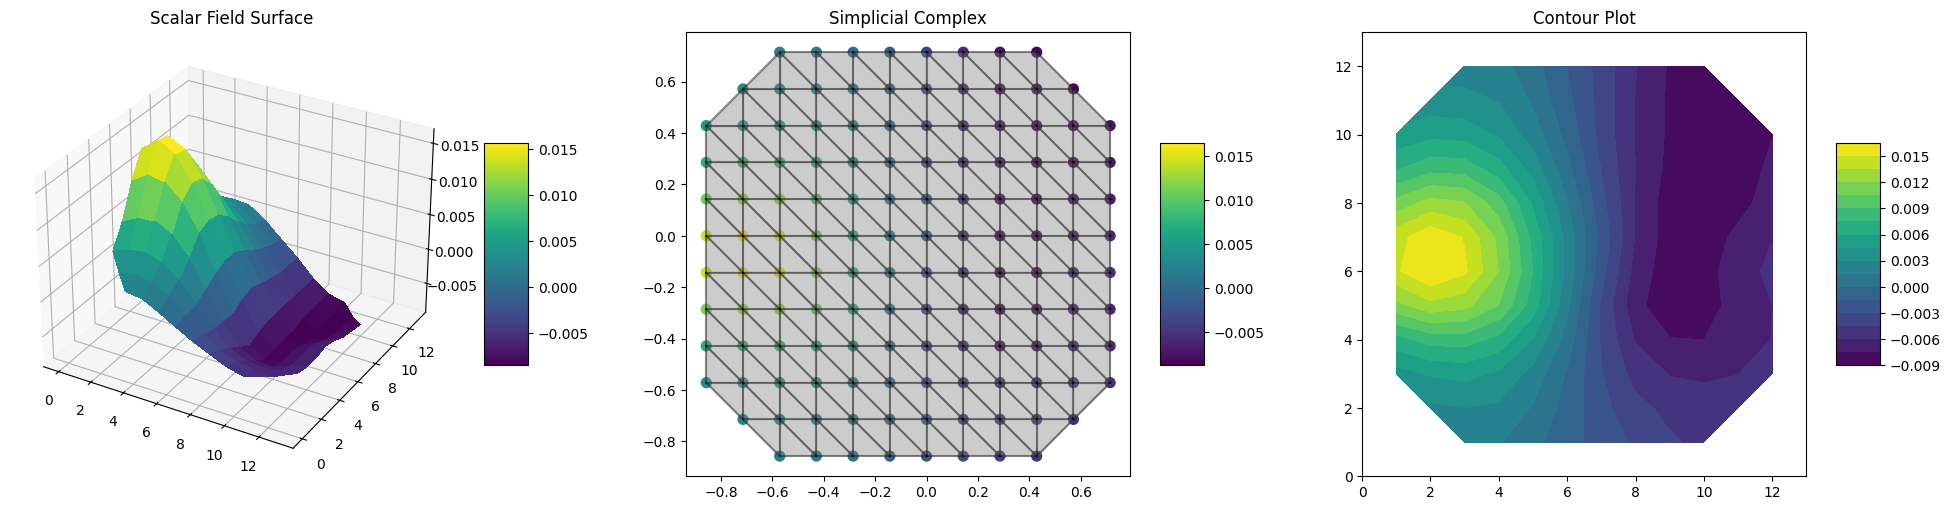

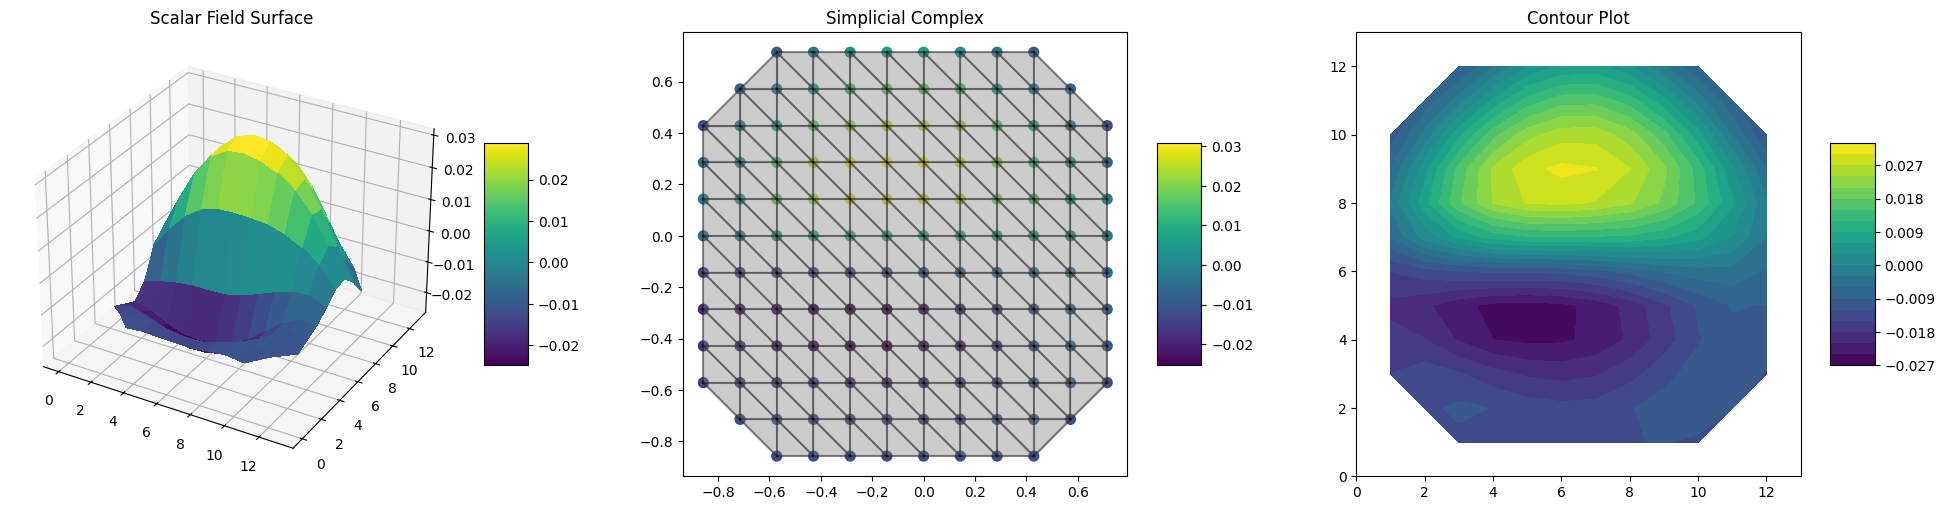

In [17]:
# Get the first mission data and compute HHD
mission = list(mission_vector_fields.keys())[0]
field, mask = mission_vector_fields[mission]

ny_bins, nx_bins = field.shape[:2]
nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(optimal_bin_widths, optimal_bin_widths))
# Create the masked array directly from the field
masked_field = ma.array(field, mask=np.dstack((~mask, ~mask)))
nhhd.decompose(masked_field)


# Extract and mask components
nD = ma.masked_where(~mask, nhhd.nD)
nRu = ma.masked_where(~mask, -nhhd.nRu)

# Visualize the simplicial complex for divergent component
st_div = createSimplexTree(nD, mask=np.dstack((~mask, ~mask)))

# Visualize the simplicial complex for rotational component
st_rot = createSimplexTree(nRu, mask=np.dstack((~mask, ~mask)))

# Understanding Topological Analysis of Scalar Fields: From Alpha Complexes to Value-based Filtration

## 1. Introduction

When analyzing vector fields using persistent homology, we typically decompose them into scalar fields (divergence and rotation) using the Helmholtz-Hodge decomposition. This raises an important question: how should we analyze the topology of these scalar fields?

## 2. Traditional Approach: Alpha Complexes

Initially, one might consider using alpha complexes, which build a filtration based on spatial relationships:

### 2.1. Alpha Complex Filtration

For a point cloud $P = \{p_1, ..., p_n\}$ in $\mathbb{R}^2$, the alpha complex filtration is built by:
- Starting with isolated points
- Gradually increasing $\alpha$ to form edges and triangles
- Creating a sequence: $K_{\alpha_1} \subset K_{\alpha_2} \subset ... \subset K_{\alpha_n}$

The birth and death times correspond to spatial distances ($\alpha$ values) where topological features appear and disappear.

### 2.2. Why This Isn't Optimal for Scalar Fields

However, for scalar fields $f: \mathbb{R}^2 \to \mathbb{R}$, this approach has several limitations:

1. **Loss of Value Information**: Alpha complexes only consider spatial relationships, ignoring the actual scalar values.
2. **Misaligned Features**: Important topological features in scalar fields often correspond to value-based relationships, not spatial ones.
3. **Grid Structure**: Our data is typically on a regular grid, making spatial filtration less meaningful.

## 3. Value-based Filtration for Scalar Fields

Instead, we should use the scalar values themselves to define our filtration.

### 3.1. Sublevel Set Filtration

For a scalar field $f$, we define the sublevel set at value $a$ as:
```math
F_a = f^{-1}(-\infty, a] = \{x \in \mathbb{R}^2 : f(x) \leq a\}
```

This gives us a filtration:
```math
F_{a_1} \subset F_{a_2} \subset ... \subset F_{a_n}
```
where $a_1 < a_2 < ... < a_n$ are the values in our scalar field.

### 3.2. Handling Signed Values

For fields like divergence with both positive and negative values, we need to consider:

1. **Positive Filtration**: Track features in $F_a^+ = \{x : 0 \leq f(x) \leq a\}$
2. **Negative Filtration**: Track features in $F_a^- = \{x : -a \leq f(x) \leq 0\}$

## 4. Implementation Using Cubical Complexes

For gridded data, we use cubical complexes instead of simplicial complexes:

```python
# Instead of:
alpha_complex = AlphaComplex(points)
st = alpha_complex.create_simplex_tree(alpha)

# We use:
cubic_complex = CubicalComplex(top_dimensional_cells=field_data)
persistence = cubic_complex.persistence()
```

## 5. Interpreting Results

### 5.1. Birth-Death Pairs

- **Birth Value**: The scalar value where a topological feature appears
- **Death Value**: The scalar value where the feature disappears

### 5.2. Physical Interpretation

For divergence fields:
- **H₀ (Components)**: 
  - Positive values: Separate source regions
  - Negative values: Separate sink regions
- **H₁ (Holes)**: 
  - Circular patterns in the flow
  - Regions enclosed by similar divergence values

For rotational fields:
- **H₀ (Components)**: Regions of distinct rotational behavior
- **H₁ (Holes)**: Nested rotational patterns

### 5.3. Persistence

The persistence of a feature is now measured in terms of scalar value difference:

This represents how "stable" a feature is across different threshold values of the scalar field.

## 6. Advantages of Value-based Analysis

1. **Direct Physical Meaning**: Features correspond to actual field behavior
2. **Better Feature Detection**: Captures structures based on field values
3. **Natural Grid Handling**: Works naturally with gridded data
4. **Separate Analysis of Behaviors**: Can analyze positive and negative regions separately


## 8. Conclusion

By transitioning from spatial (alpha-based) to value-based filtration, we obtain a more meaningful analysis of scalar fields that:
- Preserves the physical significance of the field values
- Better captures the topological features of interest
- Naturally handles the gridded nature of our data
- Allows separate analysis of different behavioral regions

This approach provides a more robust framework for understanding the topological structure of vector field decompositions and their physical interpretations.

/tmp/ipykernel_4114/3023224613.py:99: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


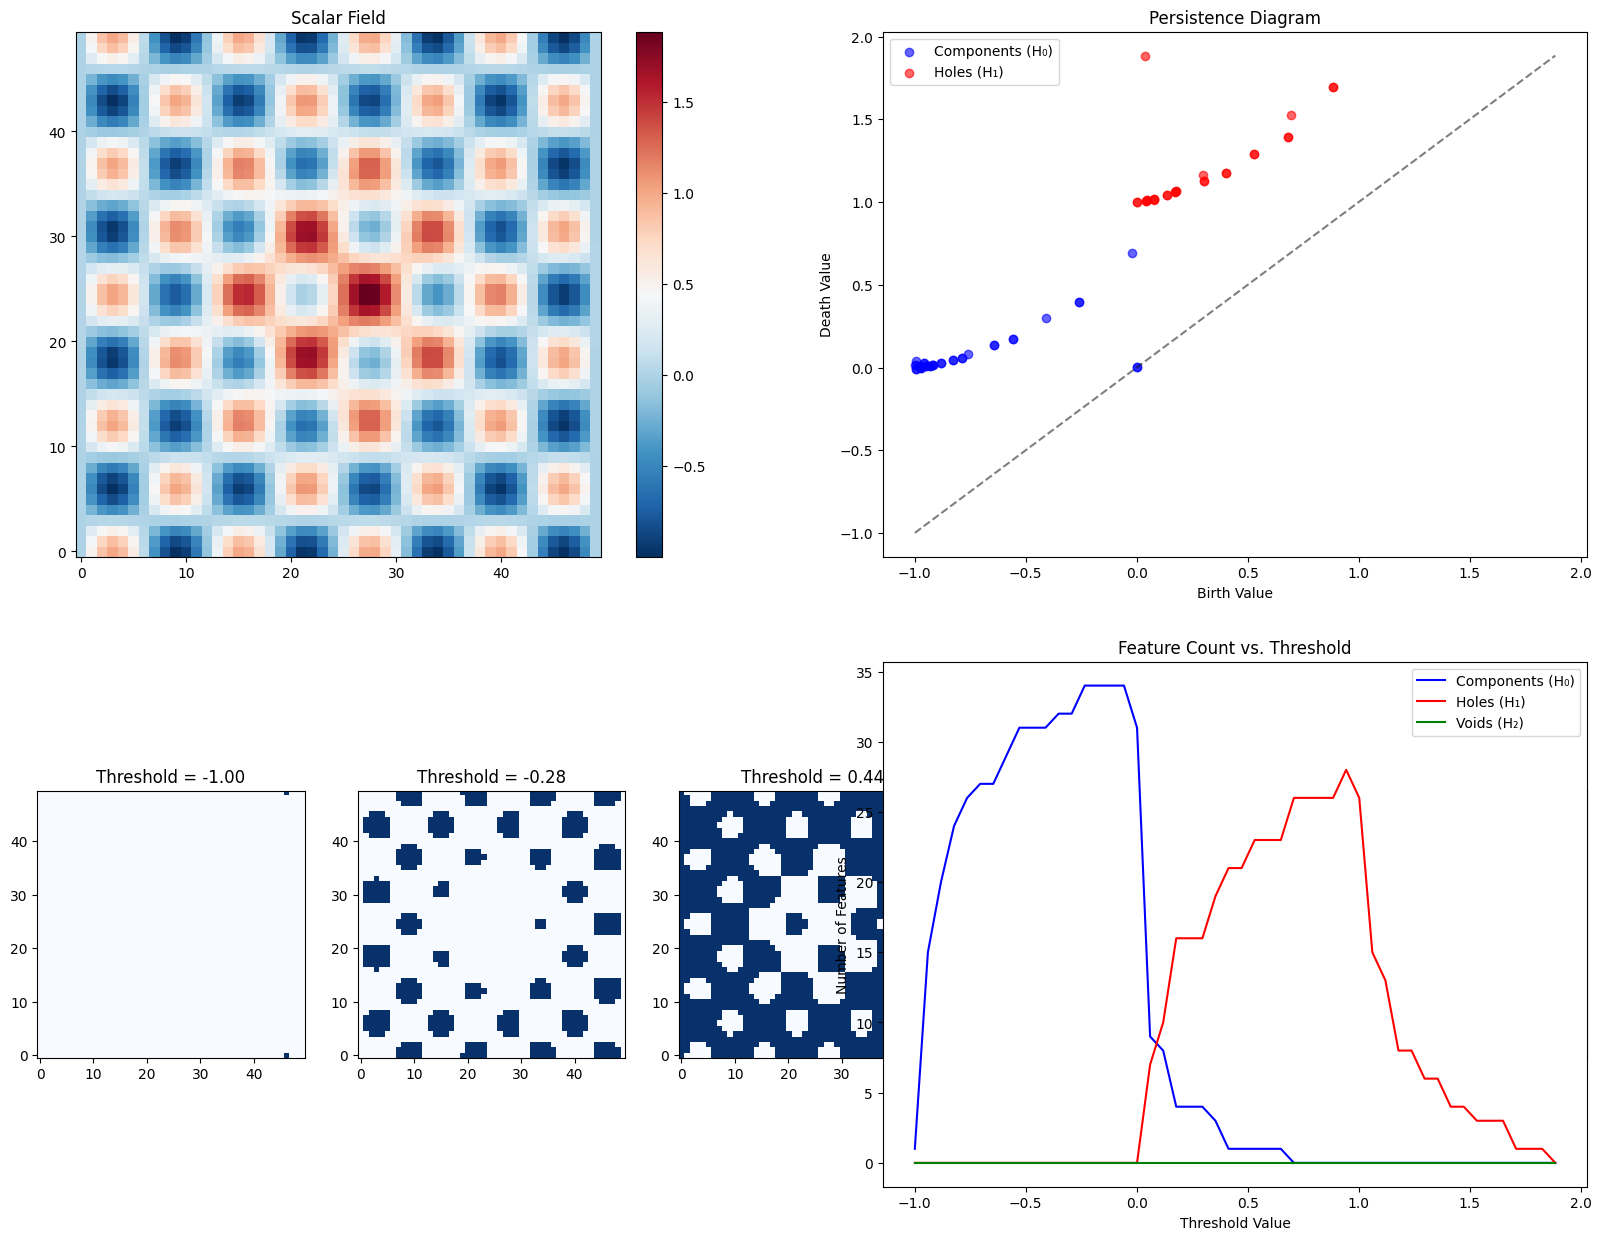

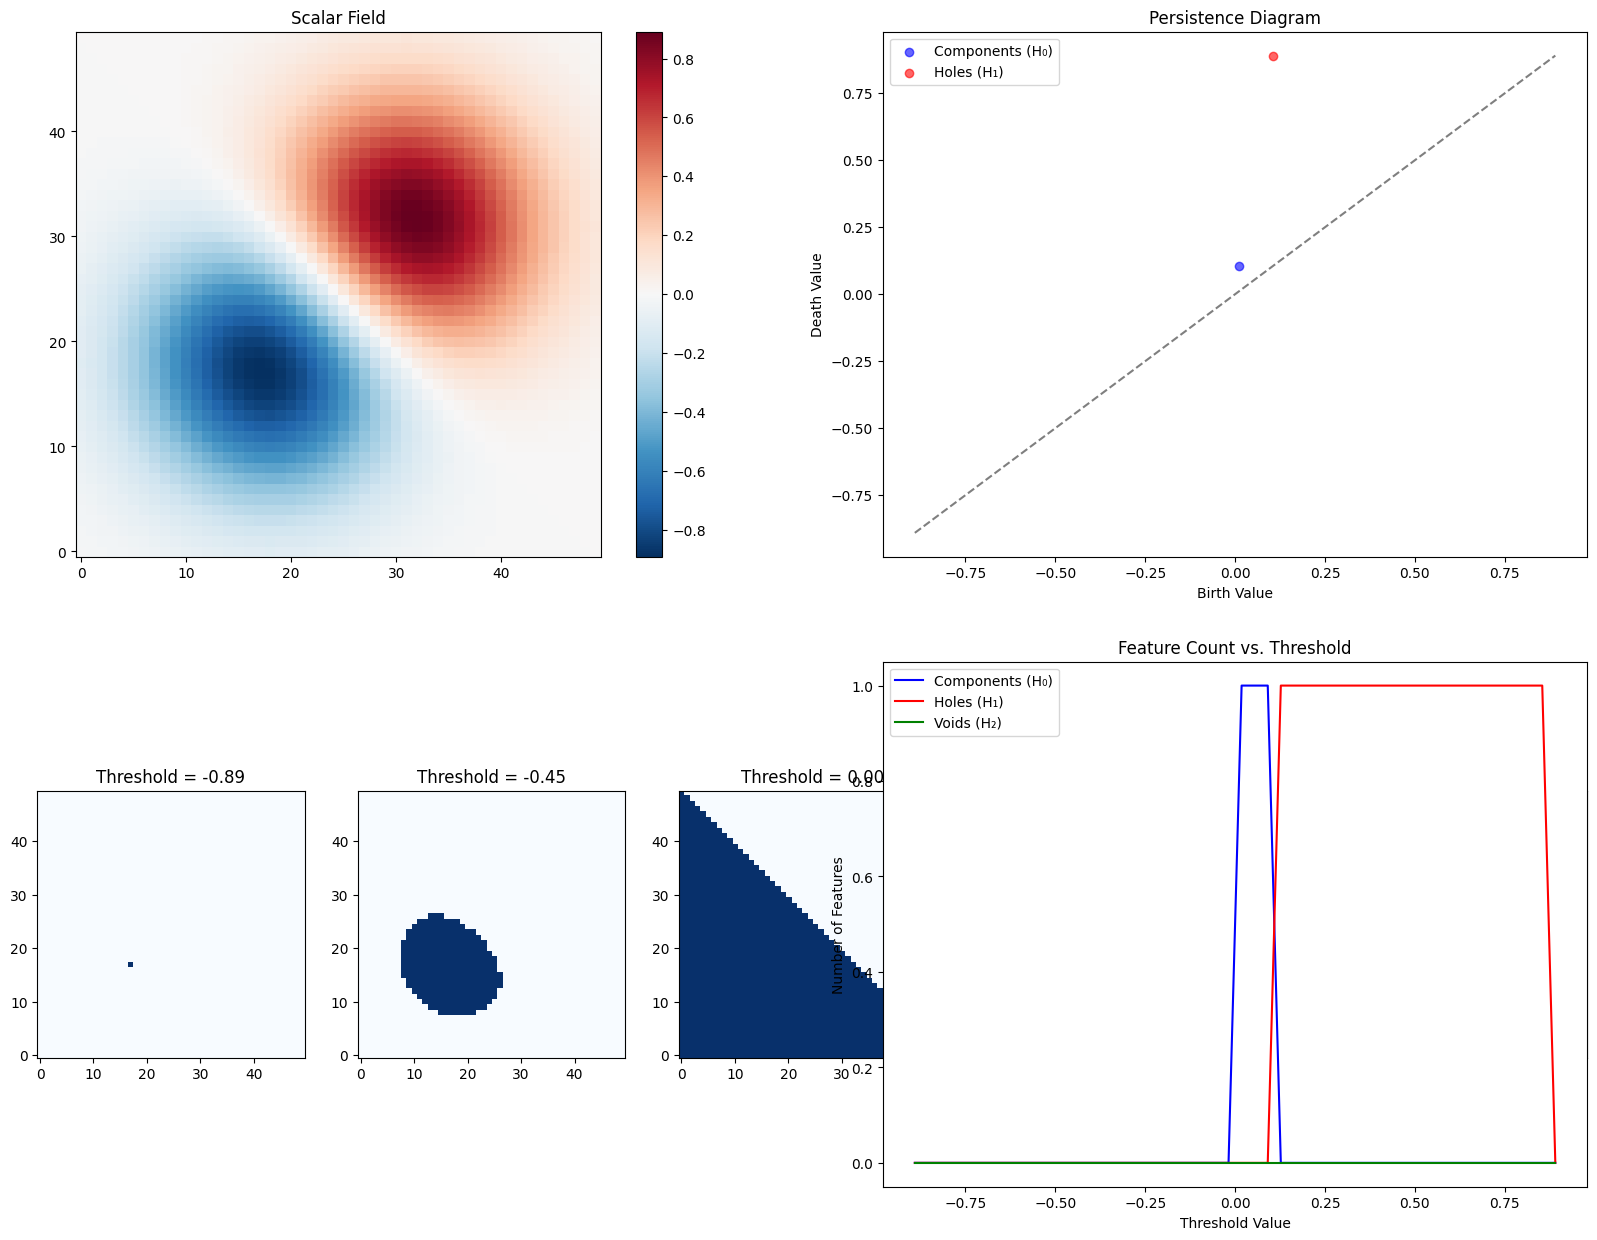

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import CubicalComplex

def explain_grid_scalar_persistence(grid_values, dx=1.0):
    """
    Computes and explains persistence diagrams for scalar fields on a regular grid.
    
    Parameters:
    grid_values: 2D numpy array containing scalar values at each grid point
    dx: grid spacing (assumed uniform in both directions)
    """
    # Create visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Visualize the scalar field
    ax_field = fig.add_subplot(2, 2, 1)
    im = ax_field.imshow(grid_values, cmap='RdBu_r', origin='lower')
    plt.colorbar(im, ax=ax_field)
    ax_field.set_title('Scalar Field')
    
    # 2. Compute persistence using Cubical Complex
    # Correct initialization of CubicalComplex
    cubic_complex = CubicalComplex(top_dimensional_cells=grid_values)
    persistence = cubic_complex.persistence()
    
    # Separate persistence pairs by dimension
    pairs_by_dim = {0: [], 1: [], 2: []}
    for pair in persistence:
        dim = pair[0]
        if dim in pairs_by_dim:
            birth = pair[1][0]
            death = pair[1][1]
            if death != float('inf'):
                pairs_by_dim[dim].append([birth, death])
    
    # Convert to numpy arrays for easier handling
    for dim in pairs_by_dim:
        if pairs_by_dim[dim]:
            pairs_by_dim[dim] = np.array(pairs_by_dim[dim])
    
    # 3. Visualize sublevel set evolution
    n_levels = 5
    levels = np.linspace(grid_values.min(), grid_values.max(), n_levels)
    
    for i, level in enumerate(levels):
        ax = fig.add_subplot(2, n_levels, n_levels + i + 1)
        mask = grid_values <= level
        ax.imshow(mask, cmap='Blues', origin='lower')
        ax.set_title(f'Threshold = {level:.2f}')
    
    # 4. Plot persistence diagram
    ax_diag = fig.add_subplot(2, 2, 2)
    
    # Plot points for each dimension with different colors
    colors = ['blue', 'red', 'green']
    labels = ['Components (H₀)', 'Holes (H₁)', 'Voids (H₂)']
    
    for dim in [0, 1, 2]:
        if len(pairs_by_dim[dim]) > 0:
            pairs = pairs_by_dim[dim]
            ax_diag.scatter(pairs[:, 0], pairs[:, 1],
                          c=colors[dim], label=labels[dim],
                          alpha=0.6)
    
    # Add diagonal line
    value_range = [grid_values.min(), grid_values.max()]
    ax_diag.plot(value_range, value_range, 'k--', alpha=0.5)
    
    ax_diag.set_xlabel('Birth Value')
    ax_diag.set_ylabel('Death Value')
    ax_diag.set_title('Persistence Diagram')
    ax_diag.legend()
    
    # 5. Compute and plot persistence statistics
    birth_values = np.linspace(grid_values.min(), grid_values.max(), 50)
    feature_counts = {0: [], 1: [], 2: []}
    
    for birth in birth_values:
        for dim in [0, 1, 2]:
            if len(pairs_by_dim[dim]) > 0:
                # Count features born before birth and dying after birth
                count = np.sum((pairs_by_dim[dim][:, 0] <= birth) & 
                             (pairs_by_dim[dim][:, 1] > birth))
                feature_counts[dim].append(count)
            else:
                feature_counts[dim].append(0)
    
    ax_stats = fig.add_subplot(2, 2, 4)
    for dim in [0, 1, 2]:
        ax_stats.plot(birth_values, feature_counts[dim],
                     c=colors[dim], label=labels[dim])
    
    ax_stats.set_xlabel('Threshold Value')
    ax_stats.set_ylabel('Number of Features')
    ax_stats.set_title('Feature Count vs. Threshold')
    ax_stats.legend()
    
    plt.tight_layout()
    
    return persistence

# Example usage with gridded data
def create_example_grid(n=50):
    x = np.linspace(-2, 2, n)
    y = np.linspace(-2, 2, n)
    X, Y = np.meshgrid(x, y)
    
    # Create a scalar field with some interesting features
    Z = np.sin(2*np.pi*X) * np.cos(2*np.pi*Y) + np.exp(-(X**2 + Y**2))
    return Z

# Create and analyze example data
n_points = 50
grid_data = create_example_grid(n_points)
persistence = explain_grid_scalar_persistence(grid_data, dx=4.0/n_points)

# If you want to analyze divergence field instead:
def create_divergence_field(n=50):
    """Create a sample divergence field with sources and sinks"""
    x = np.linspace(-2, 2, n)
    y = np.linspace(-2, 2, n)
    X, Y = np.meshgrid(x, y)
    
    # Create sources and sinks
    source1 = np.exp(-((X-0.5)**2 + (Y-0.5)**2))  # source
    sink1 = -np.exp(-((X+0.5)**2 + (Y+0.5)**2))   # sink
    
    # Combine to create divergence field
    div = source1 + sink1
    return div

# To use with divergence field:
div_field = create_divergence_field(n_points)
persistence = explain_grid_scalar_persistence(div_field, dx=4.0/n_points)

THE FOLLOYING IS ACTUALLY BAD 

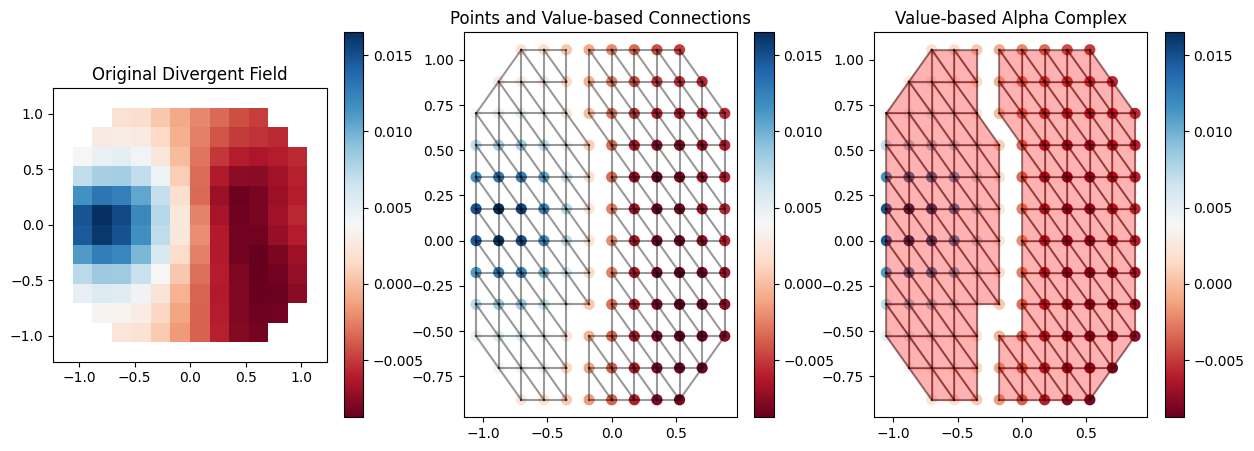

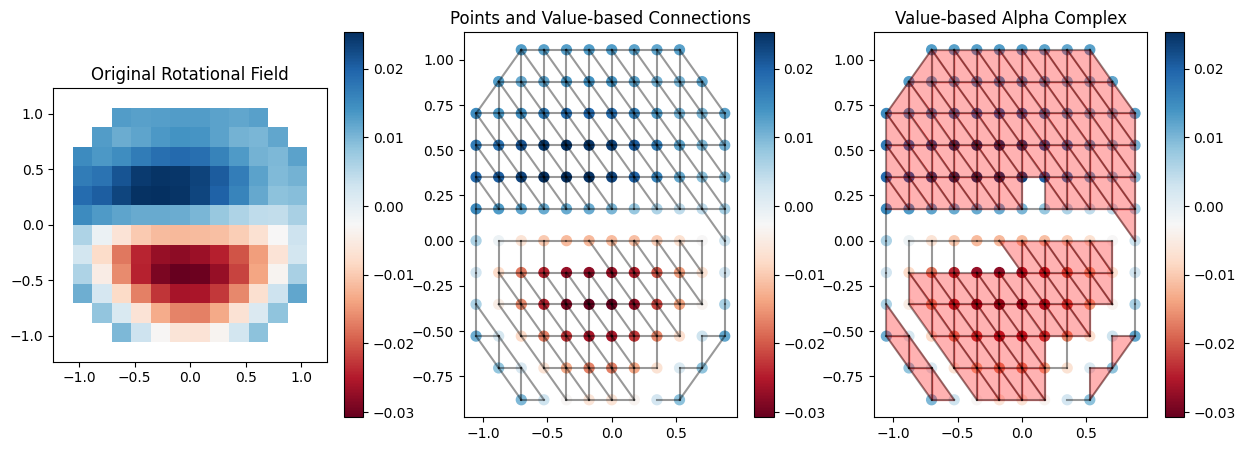

In [19]:
def visualize_topological_structure(field, mask, component_name="Divergent"):
    """Visualize the topological structure of a scalar field component"""
    # Get the scalar field (either divergent or rotational)
    ny_bins, nx_bins = field.shape[:2]
    dx = optimal_bin_widths  # Use the optimal bin width
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(dx, dx))
    masked_field = ma.array(field, mask=np.dstack((~mask, ~mask)))
    nhhd.decompose(masked_field)
    
    # Get component and mask it
    if component_name == "Divergent":
        component = ma.masked_where(~mask, nhhd.nD)
    else:  # Rotational
        component = ma.masked_where(~mask, nhhd.nRu)
    
    # Get points and their values
    m = component.mask
    r, c = np.nonzero(~m)
    values = component[~m]
    
    # Scale points to be in [-1.231, 1.231] range
    points = np.array([[2 * 1.231 * (ci/ny_bins - 0.5),  # Swap ri with ci
                    -2 * 1.231 * (ri/nx_bins - 0.5)]   # Swap ci with ri
                    for ri, ci in zip(r, c)])
    
    # Create Alpha Complex considering both position and values
    # We'll create edges only between points with similar values
    alpha_complex = AlphaComplex(points)
    st = alpha_complex.create_simplex_tree(dx**2)
    
    # Filter simplices based on field values
    filtered_edges = []
    filtered_triangles = []
    
    std_val = np.std(values)
    
    # For edges, check if values are similar and have the same sign
    for simplex in st.get_skeleton(1):
        vertices = simplex[0]
        if len(vertices) == 2:  # it's an edge
            v1, v2 = vertices
            # Check if both values have the same sign
            if np.sign(values[v1]) == np.sign(values[v2]):
                # Only keep edge if values are similar
                if abs(values[v1] - values[v2]) < std_val:  # Adjust threshold as needed
                    filtered_edges.append((v1, v2))
    
    # For triangles, check if all three vertices have similar values and same sign
    for simplex in st.get_skeleton(2):
        vertices = simplex[0]
        if len(vertices) == 3:  # it's a triangle
            v1, v2, v3 = vertices
            # Check if all vertices have the same sign
            if (np.sign(values[v1]) == np.sign(values[v2]) == np.sign(values[v3])):
                vals = [values[v1], values[v2], values[v3]]
                if np.max(vals) - np.min(vals) < std_val:  # Adjust threshold as needed
                    filtered_triangles.append((v1, v2, v3))
    
    # Visualization
    fig = plt.figure(figsize=(15, 5))
    
    # Original scalar field
    ax1 = fig.add_subplot(131)
    im = ax1.imshow(component, cmap='RdBu',
                    extent=[-1.231, 1.231, -1.231, 1.231])
    ax1.set_title(f'Original {component_name} Field')
    plt.colorbar(im, ax=ax1)
    
    # Points and value-based edges
    ax2 = fig.add_subplot(132)
    scatter = ax2.scatter(points[:, 0], points[:, 1], 
                         c=values, cmap='RdBu', 
                         s=50, label='Vertices')
    plt.colorbar(scatter, ax=ax2)
    
    # Plot filtered edges
    for v1, v2 in filtered_edges:
        ax2.plot([points[v1][0], points[v2][0]], 
                [points[v1][1], points[v2][1]], 
                'k-', alpha=0.4)
    ax2.set_title('Points and Value-based Connections')
    
    # Full filtered Alpha Complex
    ax3 = fig.add_subplot(133)
    scatter = ax3.scatter(points[:, 0], points[:, 1], 
                         c=values, cmap='RdBu', 
                         s=50, label='Vertices')
    plt.colorbar(scatter, ax=ax3)
    
    # Plot filtered edges and triangles
    for v1, v2 in filtered_edges:
        ax3.plot([points[v1][0], points[v2][0]], 
                [points[v1][1], points[v2][1]], 
                'k-', alpha=0.4)
    
    for v1, v2, v3 in filtered_triangles:
        triangle = plt.Polygon(np.array([points[v1], points[v2], points[v3]]), 
                             alpha=0.3, color='red')
        ax3.add_patch(triangle)
    ax3.set_title('Value-based Alpha Complex')
    


# Use it for both components
mission = list(mission_vector_fields.keys())[0]
field, mask = mission_vector_fields[mission]

# Visualize for divergent component
visualize_topological_structure(field, mask, "Divergent")

# Visualize for rotational component
visualize_topological_structure(field, mask, "Rotational")

In [22]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
from gudhi import SimplexTree, AlphaComplex
from gudhi.wasserstein import wasserstein_distance


In [23]:
def create_enhanced_3d_structure(field, mask, component_name="Divergent"):
    """
    Crée une structure 3D qui préserve les structures distinctes tout en les analysant ensemble.
    """
    # Get the scalar field
    ny_bins, nx_bins = field.shape[:2]
    dx = optimal_bin_widths
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(dx, dx))
    masked_field = ma.array(field, mask=np.dstack((~mask, ~mask)))
    nhhd.decompose(masked_field)

    
    if component_name == "Divergent":
        component = ma.masked_where(~mask, nhhd.nD)
    else:
        component = ma.masked_where(~mask, nhhd.nRu)
    
    # Get points and values
    m = component.mask
    r, c = np.nonzero(~m)
    values = component[~m]
    scale = 1.231
    
    # Create base points
    points = np.array([[2 * scale * (ci/ny_bins - 0.5),
                       -2 * scale * (ri/nx_bins - 0.5)]
                      for ri, ci in zip(r, c)])
    
    # Create Alpha Complex for base connectivity
    alpha_complex = AlphaComplex(points)
    st = alpha_complex.create_simplex_tree(dx*10)
    
    # Filter based on values
    std_val = np.std(values)
    
    # Structures pour les différentes régions
    structures = {
        'strong_positive': {'values': values > std_val},
        'weak_positive': {'values': (values <= std_val) & (values > 0)},
        'weak_negative': {'values': (values >= -std_val) & (values < 0)},
        'strong_negative': {'values': values < -std_val}
    }
    
    # Filtrer les edges et triangles pour chaque structure
    for name in structures:
        structures[name]['edges'] = []
        structures[name]['triangles'] = []
    
    # Filter edges within each structure
    for simplex in st.get_skeleton(1):
        vertices = simplex[0]
        if len(vertices) == 2:
            v1, v2 = vertices
            val1, val2 = values[v1], values[v2]
            
            # Check for each structure
            if abs(val1 - val2) < std_val:  # Similar values condition
                for name, struct in structures.items():
                    if struct['values'][v1] and struct['values'][v2]:
                        struct['edges'].append((v1, v2))
    
    # Filter triangles within each structure
    for simplex in st.get_skeleton(2):
        vertices = simplex[0]
        if len(vertices) == 3:
            v1, v2, v3 = vertices
            vals = [values[v1], values[v2], values[v3]]
            
            if np.max(vals) - np.min(vals) < std_val:  # Similar values condition
                for name, struct in structures.items():
                    if (struct['values'][v1] and 
                        struct['values'][v2] and 
                        struct['values'][v3]):
                        struct['triangles'].append((v1, v2, v3))
    
    # Create 3D points with actual values as height
    points_3d = np.column_stack([points, values])
    
    # Create unified SimplexTree with all structures
    st_unified = SimplexTree()
    
    # Add all vertices
    for idx, point in enumerate(points_3d):
        st_unified.insert([idx], filtration=point[2])
    
    # Add edges and triangles from all structures
    for struct in structures.values():
        # Add edges
        for v1, v2 in struct['edges']:
            max_val = max(abs(points_3d[v1][2]), abs(points_3d[v2][2]))
            st_unified.insert([v1, v2], filtration=max_val)
        
        # Add triangles
        for v1, v2, v3 in struct['triangles']:
            max_val = max(abs(points_3d[v1][2]), 
                         abs(points_3d[v2][2]),
                         abs(points_3d[v3][2]))
            st_unified.insert([v1, v2, v3], filtration=max_val)
    
    st_unified.make_filtration_non_decreasing()
    
    return points_3d, structures, st_unified, values

def visualize_enhanced_structure(points_3d, structures, st_unified, values, component_name):
    """
    Visualise la structure 3D avec les différentes régions.
    """
    fig = plt.figure(figsize=(20, 10))
    
    # Colors for different structures
    colors = {
        'strong_positive': 'darkred',
        'weak_positive': 'lightcoral',
        'weak_negative': 'lightblue',
        'strong_negative': 'darkblue'
    }
    
    # 1. Structure separation view
    ax1 = fig.add_subplot(231, projection='3d')
    for name, struct in structures.items():
        mask = struct['values']
        if np.any(mask):
            ax1.scatter(points_3d[mask, 0], 
                       points_3d[mask, 1], 
                       points_3d[mask, 2],
                       c=colors[name], label=name, alpha=0.6)
    ax1.set_title('Separated Structures')
    ax1.legend()
    
    # 2. Edges within structures
    ax2 = fig.add_subplot(232, projection='3d')
    for name, struct in structures.items():
        # Plot points
        mask = struct['values']
        if np.any(mask):
            ax2.scatter(points_3d[mask, 0], 
                       points_3d[mask, 1], 
                       points_3d[mask, 2],
                       c=colors[name], alpha=0.3)
        
        # Plot edges
        for v1, v2 in struct['edges']:
            ax2.plot([points_3d[v1, 0], points_3d[v2, 0]],
                    [points_3d[v1, 1], points_3d[v2, 1]],
                    [points_3d[v1, 2], points_3d[v2, 2]],
                    c=colors[name], alpha=0.2)
    ax2.set_title('Edges Within Structures')
    
    # 3. Complete structure with triangles
    ax3 = fig.add_subplot(233, projection='3d')
    for name, struct in structures.items():
        # Plot triangles
        for v1, v2, v3 in struct['triangles']:
            vertices = np.array([points_3d[v1], points_3d[v2], points_3d[v3]])
            tri = art3d.Poly3DCollection([vertices])
            tri.set_alpha(0.3)
            tri.set_color(colors[name])
            ax3.add_collection3d(tri)
    
    ax3.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                c=points_3d[:, 2], cmap='RdBu_r', alpha=0.2)
    ax3.set_title('Complete Structure')
    
    # 4. Persistence diagram for combined structure
    ax4 = fig.add_subplot(234)
    persistence = st_unified.persistence()
    
    colors_dim = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    labels = ['H₀', 'H₁', 'H₂']
    
    for dim in [0, 1, 2]:
        pairs = np.array([[birth, death] for d, (birth, death) in persistence if d == dim])
        if len(pairs) > 0:
            ax4.scatter(pairs[:, 0], pairs[:, 1],
                       c=colors_dim[dim], marker=markers[dim],
                       label=labels[dim], alpha=0.6)
    
    # Add diagonal
    lims = ax4.get_xlim() + ax4.get_ylim()
    min_val, max_val = min(lims), max(lims)
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax4.set_title('Combined Persistence Diagram')
    ax4.legend()
    
    # 5. Structure statistics
    ax5 = fig.add_subplot(235)
    ax5.axis('off')
    stats_text = []
    for name, struct in structures.items():
        stats_text.extend([
            f"{name}:",
            f"  Points: {np.sum(struct['values'])}",
            f"  Edges: {len(struct['edges'])}",
            f"  Triangles: {len(struct['triangles'])}",
            ""
        ])
    ax5.text(0.1, 0.9, "\n".join(stats_text),
             transform=ax5.transAxes, 
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def analyze_enhanced_component(field, mask, component_name="Divergent"):
    """
    Analyse complète d'une composante avec structures séparées mais analysées ensemble.
    """
    points_3d, structures, st_unified, values = create_enhanced_3d_structure(
        field, mask, component_name
    )
    
    visualize_enhanced_structure(points_3d, structures, st_unified, values, component_name)
    
    return points_3d, structures, st_unified, values

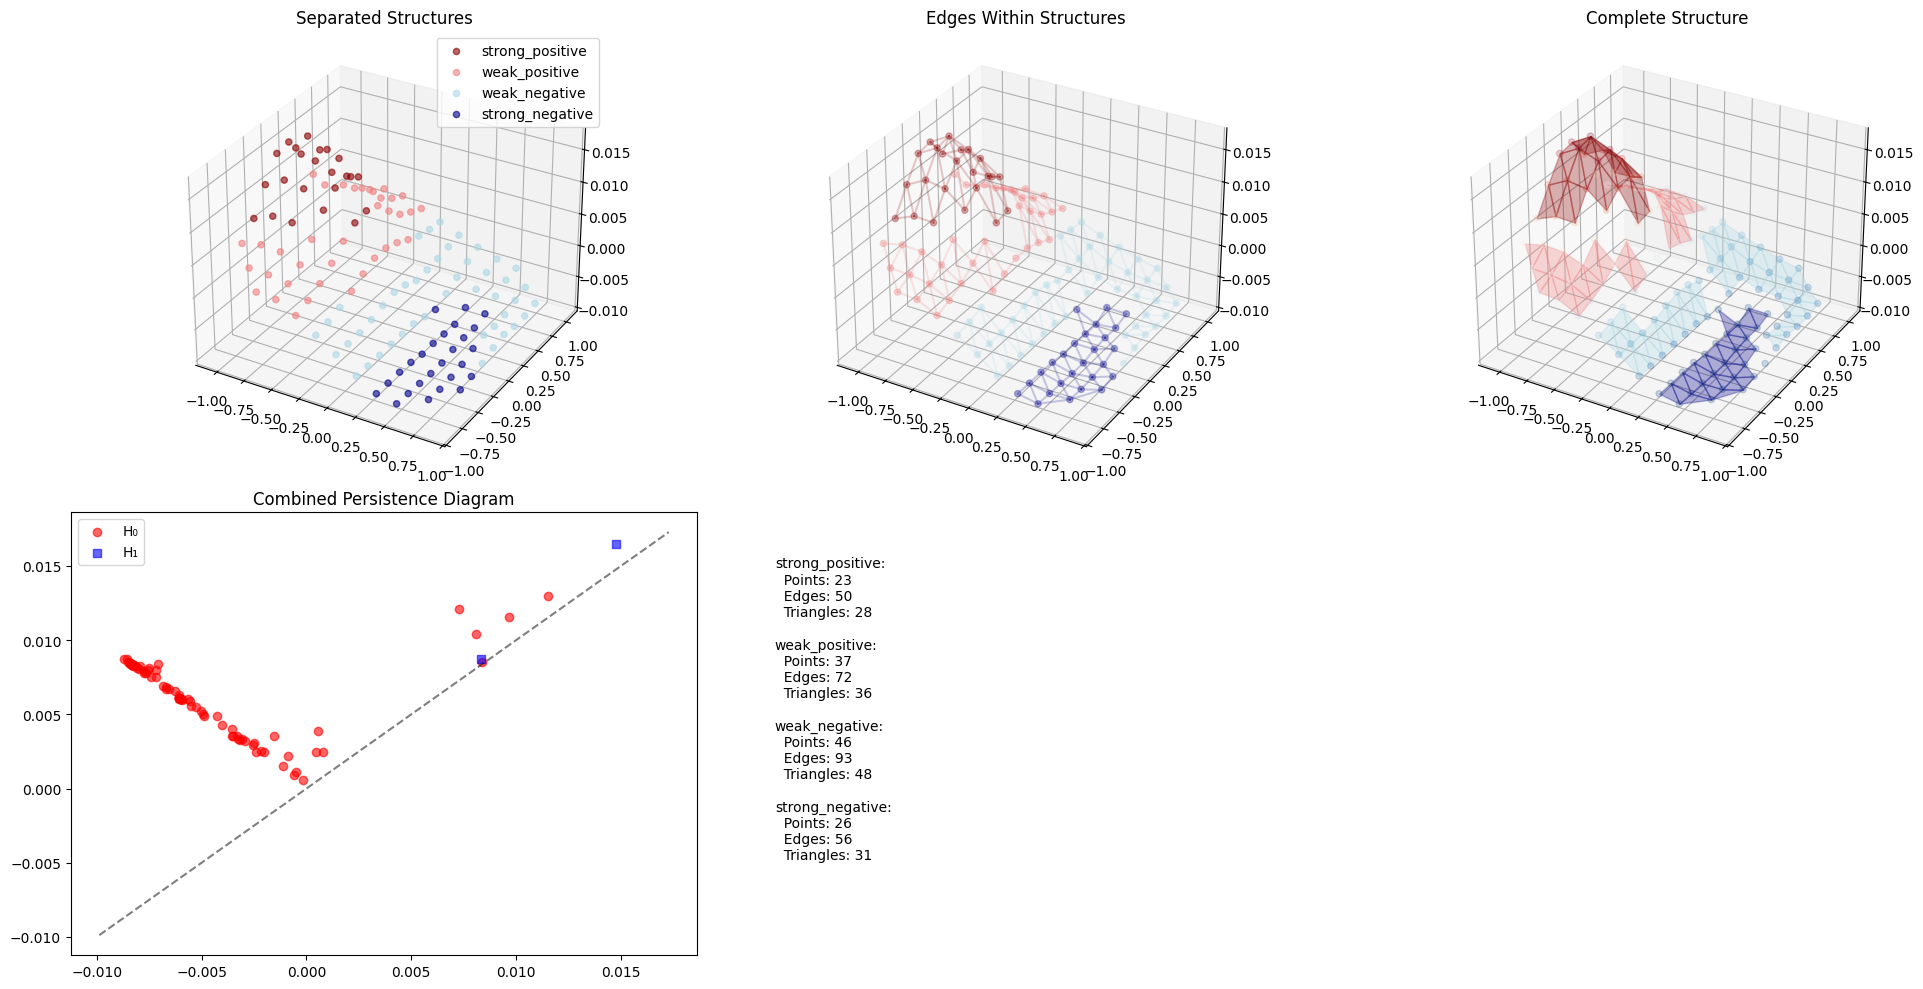

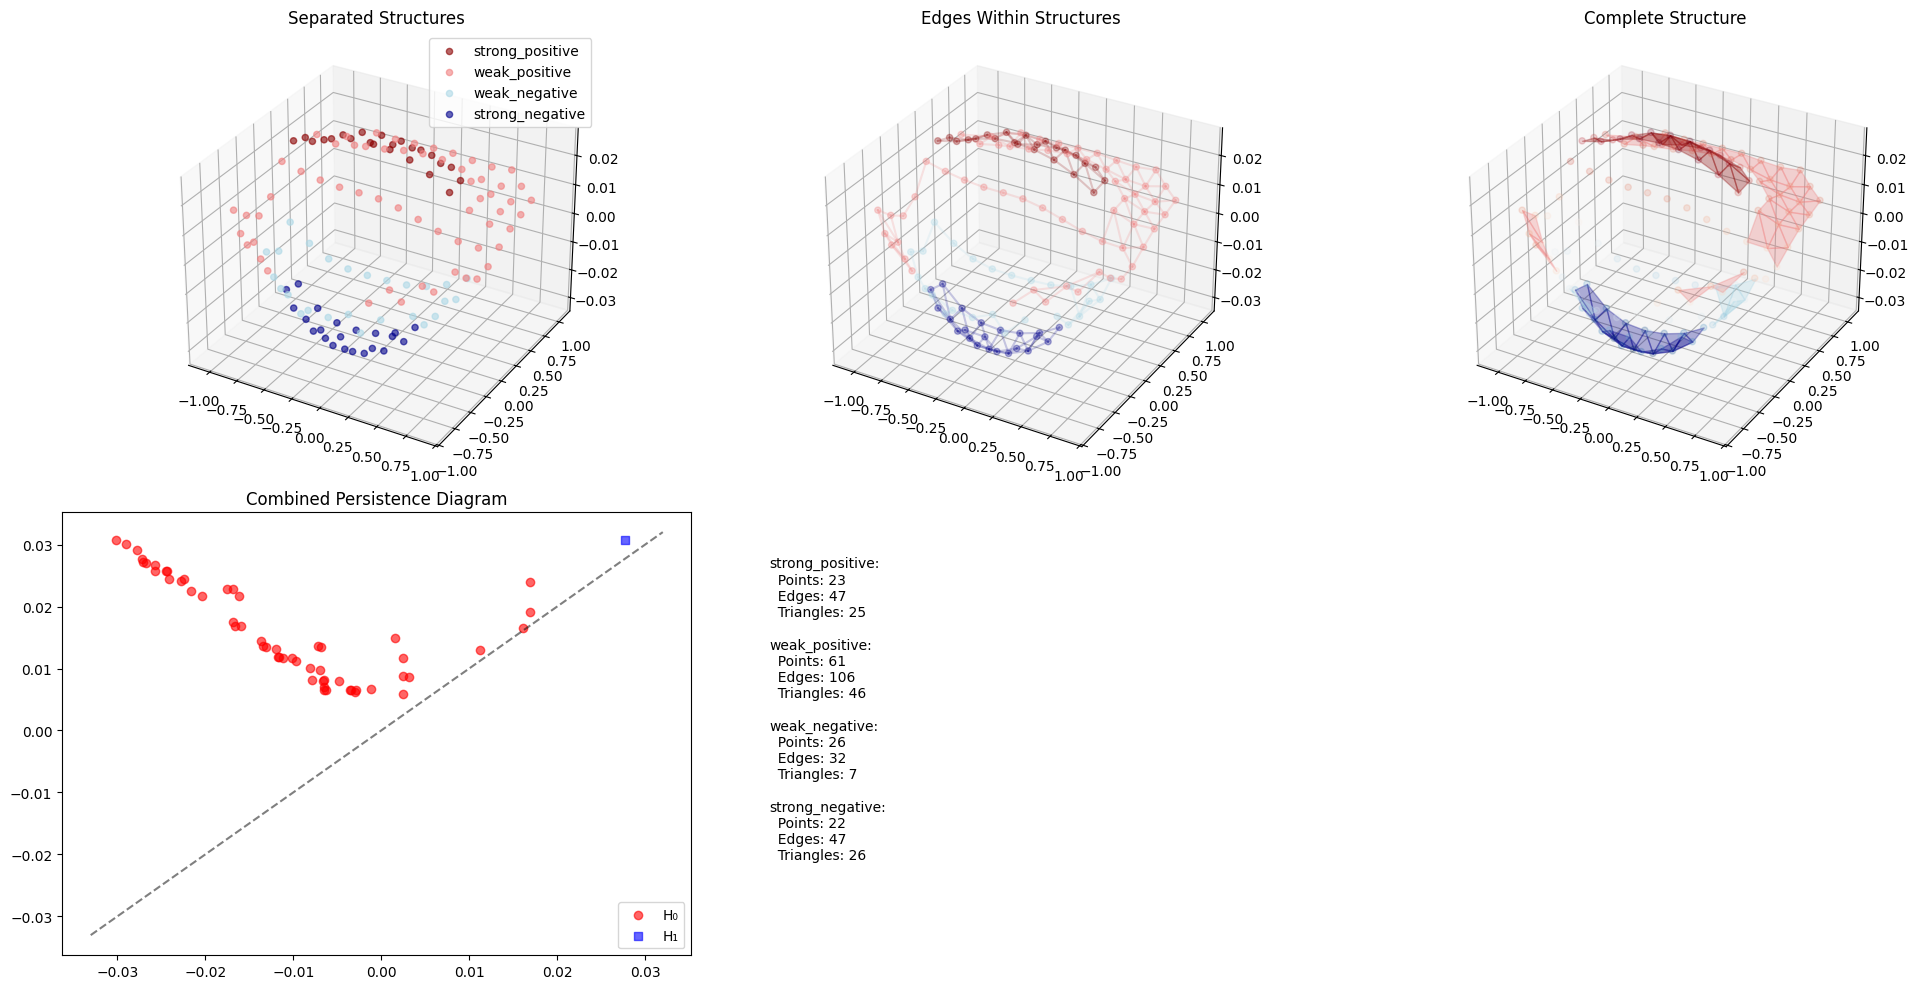

In [24]:
# Pour analyser une mission/run
mission = list(mission_vector_fields.keys())[0]
field, mask = mission_vector_fields[mission]

# Analyser la composante divergente
div_points, div_structures, div_st, div_values = analyze_enhanced_component(
    field, mask, "Divergent"
)

# Analyser la composante rotationnelle
rot_points, rot_structures, rot_st, rot_values = analyze_enhanced_component(
    field, mask, "Rotational"
)

In [65]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
from gudhi import SimplexTree, AlphaComplex
from gudhi.wasserstein import wasserstein_distance
from pynhhd import nHHD

def create_value_based_structure(field, mask, component_name="Divergent"):
    """
    Crée une structure 3D en séparant les valeurs positives et négatives du champ.
    """
    # Get the scalar field
    ny_bins, nx_bins = field.shape[:2]
    dx = optimal_bin_widths
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(dx, dx))
    masked_field = ma.array(field, mask=np.dstack((~mask, ~mask)))
    nhhd.decompose(masked_field)

    
    if component_name == "Divergent":
        component = ma.masked_where(~mask, nhhd.nD)
    else:
        component = ma.masked_where(~mask, nhhd.nRu)
    
    # Get points and values
    m = component.mask
    r, c = np.nonzero(~m)
    values = component[~m]
    scale = 1.231
    
    # Create initial points array avec les coordonnées x,y
    points = np.array([[2 * scale * (ci/ny_bins - 0.5),
                       -2 * scale * (ri/nx_bins - 0.5)]
                      for ri, ci in zip(r, c)])
    
    # Create Alpha Complex for initial connectivity en 2D
    alpha_complex = AlphaComplex(points)
    st = alpha_complex.create_simplex_tree(20)
    
    # Filter based on values
    std_val = np.std(values)
    
    # Create edges and triangles based on similar values and sign
    filtered_edges = []
    filtered_triangles = []
    
    # Filter edges
    for simplex in st.get_skeleton(1):
        vertices = simplex[0]
        if len(vertices) == 2:
            v1, v2 = vertices
            # Check if values are similar and have the same sign
            if np.sign(values[v1]) == np.sign(values[v2]):
                if abs(values[v1] - values[v2]) < std_val:
                    filtered_edges.append((v1, v2))
    
    # Filter triangles
    for simplex in st.get_skeleton(2):
        vertices = simplex[0]
        if len(vertices) == 3:
            v1, v2, v3 = vertices
            if (np.sign(values[v1]) == np.sign(values[v2]) == np.sign(values[v3])):
                vals = [values[v1], values[v2], values[v3]]
                if np.max(vals) - np.min(vals) < std_val:
                    filtered_triangles.append((v1, v2, v3))
    
    # Create 3D points by adding values as z-coordinate
    points_3d = np.column_stack([points, values])
    
    return points_3d, filtered_edges, filtered_triangles, values

def create_3d_persistence_diagram(points_3d, edges, triangles):
    """
    Calcule le diagramme de persistance sur la surface 3D.
    """
    # Create Alpha Complex directly on 3D points
    alpha_complex_3d = AlphaComplex(points=points_3d)
    st_3d = alpha_complex_3d.create_simplex_tree()
    
    # Add filtered edges and triangles to control the topology
    for v1, v2 in edges:
        st_3d.insert([v1, v2])
    
    for v1, v2, v3 in triangles:
        st_3d.insert([v1, v2, v3])
    
    # Compute persistence
    persistence = st_3d.persistence()
    
    # Separate by dimension
    persistence_by_dim = {
        0: [],  # components
        1: [],  # tunnels (loops)
        2: []   # voids
    }
    
    for dim, (birth, death) in persistence:
        if dim in persistence_by_dim:
            if np.isinf(death):
                # Use max value as death for infinite persistence
                death = np.max(points_3d[:, 2])
            persistence_by_dim[dim].append([birth, death])
    
    return {dim: np.array(pairs) if pairs else np.zeros((0, 2))
            for dim, pairs in persistence_by_dim.items()}

def visualize_3d_structure(points_3d, edges, triangles, values, persistence, component_name):
    """
    Visualise la structure 3D et son diagramme de persistance.
    """
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Points 3D
    ax1 = fig.add_subplot(231, projection='3d')
    scatter = ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                         c=values, cmap='RdBu_r')
    plt.colorbar(scatter, ax=ax1)
    ax1.set_title('3D Points')
    
    # 2. Structure with edges
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                c=values, cmap='RdBu_r', alpha=0.6)
    
    for v1, v2 in edges:
        ax2.plot([points_3d[v1, 0], points_3d[v2, 0]],
                [points_3d[v1, 1], points_3d[v2, 1]],
                [points_3d[v1, 2], points_3d[v2, 2]],
                'k-', alpha=0.2)
    ax2.set_title('Structure with Edges')
    
    # 3. Complete structure with triangles
    ax3 = fig.add_subplot(233, projection='3d')
    ax3.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                c=values, cmap='RdBu_r', alpha=0.3)
    
    for v1, v2, v3 in triangles:
        vertices = np.array([points_3d[v1], points_3d[v2], points_3d[v3]])
        tri = art3d.Poly3DCollection([vertices])
        tri.set_alpha(0.3)
        mean_z = np.mean([points_3d[v1, 2], points_3d[v2, 2], points_3d[v3, 2]])
        if mean_z > 0:
            tri.set_color('red')
        else:
            tri.set_color('blue')
        ax3.add_collection3d(tri)
    ax3.set_title('Complete Structure')
    
    # 4. Persistence diagram
    ax4 = fig.add_subplot(234)
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    labels = ['H₀ (Components)', 'H₁ (Tunnels)', 'H₂ (Voids)']
    
    for dim in [0, 1, 2]:
        if len(persistence[dim]) > 0:
            ax4.scatter(persistence[dim][:, 0], persistence[dim][:, 1],
                       c=colors[dim], marker=markers[dim],
                       label=labels[dim], alpha=0.6)
    
    # Add diagonal
    lims = ax4.get_xlim() + ax4.get_ylim()
    min_val, max_val = min(lims), max(lims)
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax4.set_title('Persistence Diagram')
    ax4.legend()
    
    # 5. Statistics
    ax5 = fig.add_subplot(235)
    ax5.axis('off')
    stats_text = [
        f"{component_name} Component:",
        f"Number of points: {len(points_3d)}",
        f"Number of edges: {len(edges)}",
        f"Number of triangles: {len(triangles)}",
        "\nTopological Features:",
        *[f"{labels[i]}: {len(persistence[i])}" for i in range(3)]
    ]
    ax5.text(0.1, 0.9, "\n".join(stats_text),
             transform=ax5.transAxes,
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()


In [66]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
from gudhi import SimplexTree, AlphaComplex
from pynhhd import nHHD

def identify_surface_triangles(triangles, min_connected_triangles=5):
    """
    Identifie les triangles qui forment une surface continue.
    """
    # Créer un graphe de connectivité des triangles
    triangle_neighbors = {}
    for i, tri1 in enumerate(triangles):
        triangle_neighbors[i] = set()
        for j, tri2 in enumerate(triangles):
            if i != j:
                # Deux triangles sont connectés s'ils partagent une arête
                shared_vertices = set(tri1) & set(tri2)
                if len(shared_vertices) == 2:
                    triangle_neighbors[i].add(j)

    # Trouver les composantes connexes
    visited = set()
    components = []
    
    def dfs(triangle_idx, current_component):
        visited.add(triangle_idx)
        current_component.add(triangle_idx)
        for neighbor in triangle_neighbors[triangle_idx]:
            if neighbor not in visited:
                dfs(neighbor, current_component)
    
    # Identifier toutes les composantes
    for triangle_idx in range(len(triangles)):
        if triangle_idx not in visited:
            current_component = set()
            dfs(triangle_idx, current_component)
            components.append(current_component)
    
    # Ne garder que les composantes assez grandes
    valid_components = [comp for comp in components 
                       if len(comp) >= min_connected_triangles]
    
    return [triangles[i] for i in sorted(set().union(*valid_components))] if valid_components else []

def create_3d_surface(field, mask, component_name="Divergent", min_surface_size=5):
    """
    Crée une surface 3D à partir du champ vectoriel.
    """
    # Get the scalar field
    ny_bins, nx_bins = field.shape[:2]
    dx = optimal_bin_widths
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(dx, dx))
    nhhd.decompose(field)
    
    if component_name == "Divergent":
        component = ma.masked_where(~mask, nhhd.nD)
    else:
        component = ma.masked_where(~mask, nhhd.nRu)
    
    # Get points and values
    m = component.mask
    r, c = np.nonzero(~m)
    values = component[~m]
    scale = 1.231
    std_val = np.std(values)
    
    # Create 3D points
    points_3d = np.array([[2 * scale * (ci/ny_bins - 0.5),
                          -2 * scale * (ri/nx_bins - 0.5),
                          float(values[i])]
                         for i, (ri, ci) in enumerate(zip(r, c))])
    
    # Classifier les points par région
    regions = {
        'strong_positive': values > std_val,
        'weak_positive': (values <= std_val) & (values > 0),
        'weak_negative': (values < 0) & (values >= -std_val),
        'strong_negative': values < -std_val
    }
    
    # Create initial alpha complex in 2D
    points_2d = points_3d[:, :2]
    alpha_complex_2d = AlphaComplex(points_2d)
    st_2d = alpha_complex_2d.create_simplex_tree(dx**2)
    
    # Créer les triangles pour chaque région
    all_triangles = []
    for region_name, region_mask in regions.items():
        region_triangles = []
        for simplex in st_2d.get_skeleton(2):
            vertices = simplex[0]
            if len(vertices) == 3:
                v1, v2, v3 = vertices
                if all(region_mask[[v1, v2, v3]]):
                    region_triangles.append((v1, v2, v3))
        
        surface_triangles = identify_surface_triangles(region_triangles, min_surface_size)
        all_triangles.extend(surface_triangles)
    
    # Identifier les points utilisés
    used_points = set()
    for triangle in all_triangles:
        used_points.update(triangle)
    
    # Créer une nouvelle numérotation
    point_mapping = {old_idx: new_idx 
                    for new_idx, old_idx in enumerate(sorted(used_points))}
    
    # Recréer les points et triangles
    new_points = points_3d[sorted(used_points)]
    new_triangles = [(point_mapping[v1], point_mapping[v2], point_mapping[v3])
                     for v1, v2, v3 in all_triangles]
    
    # Garder track des régions
    new_values = values[sorted(used_points)]
    point_regions = {}
    for region_name, region_mask in regions.items():
        point_regions[region_name] = region_mask[sorted(used_points)]
    
    return new_points, new_triangles, new_values, point_regions

def visualize_3d_surface(points_3d, triangles, values, point_regions, title=""):
    """
    Crée une visualisation 3D interactive de la surface.
    """
    # Utiliser le backend interactif
    plt.ion()
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Couleurs par région
    colors = {
        'strong_positive': 'darkred',
        'weak_positive': 'lightcoral',
        'weak_negative': 'lightblue',
        'strong_negative': 'darkblue'
    }
    
    # Afficher les triangles d'abord
    for v1, v2, v3 in triangles:
        vertices = np.array([points_3d[v1], points_3d[v2], points_3d[v3]])
        tri = art3d.Poly3DCollection([vertices])
        tri.set_alpha(0.3)
        mean_z = np.mean(vertices[:, 2])
        tri.set_color('red' if mean_z > 0 else 'blue')
        ax.add_collection3d(tri)
    
    # Afficher les points par région
    for region_name, region_mask in point_regions.items():
        if np.any(region_mask):
            region_points = points_3d[region_mask]
            ax.scatter(region_points[:, 0],
                      region_points[:, 1],
                      region_points[:, 2],
                      c=colors[region_name],
                      label=region_name,
                      alpha=0.6,
                      s=50)
    
    # Ajuster les limites et les labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Placer la légende à un endroit qui ne chevauche pas
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    
    # Ajuster la disposition pour éviter les chevauchements
    plt.tight_layout()
    
    return fig, ax

# Fonction de test
def test_visualization():
    """
    Fonction pour tester la création et visualisation de surface.
    """
    mission = list(mission_vector_fields.keys())[3]
    field, mask = mission_vector_fields[mission]
    
    points, triangles, values, regions = create_3d_surface(
        field, mask, "Divergent"
    )
    
    fig, ax = visualize_3d_surface(
        points, triangles, values, regions,
        title="Test Surface"
    )
    
    return fig, ax

In [67]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import plotly.graph_objects as go
from gudhi import SimplexTree, AlphaComplex
from pynhhd import nHHD

def identify_surface_triangles(triangles, min_connected_triangles=5):
    """
    Identifie les triangles qui forment une surface continue.
    """
    # Créer un graphe de connectivité des triangles
    triangle_neighbors = {}
    for i, tri1 in enumerate(triangles):
        triangle_neighbors[i] = set()
        for j, tri2 in enumerate(triangles):
            if i != j:
                # Deux triangles sont connectés s'ils partagent une arête
                shared_vertices = set(tri1) & set(tri2)
                if len(shared_vertices) == 2:  # Une arête partagée
                    triangle_neighbors[i].add(j)

    # Trouver les composantes connexes
    visited = set()
    components = []
    
    def dfs(triangle_idx, current_component):
        visited.add(triangle_idx)
        current_component.add(triangle_idx)
        for neighbor in triangle_neighbors[triangle_idx]:
            if neighbor not in visited:
                dfs(neighbor, current_component)
    
    # Identifier toutes les composantes
    for triangle_idx in range(len(triangles)):
        if triangle_idx not in visited:
            current_component = set()
            dfs(triangle_idx, current_component)
            components.append(current_component)
    
    # Ne garder que les composantes assez grandes
    valid_components = [comp for comp in components 
                       if len(comp) >= min_connected_triangles]
    
    # Récupérer les triangles valides
    valid_triangles = []
    valid_triangle_indices = set()
    for comp in valid_components:
        valid_triangle_indices.update(comp)
    
    return [triangles[i] for i in sorted(valid_triangle_indices)]

def create_3d_surface(field, mask, component_name="Divergent", min_surface_size=5):
    """
    Crée une surface 3D à partir du champ vectoriel en ne gardant que les vraies surfaces.
    """
    # Get the scalar field
    ny_bins, nx_bins = field.shape[:2]
    dx = optimal_bin_widths
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=(dx, dx))
    nhhd.decompose(field)
    
    if component_name == "Divergent":
        component = ma.masked_where(~mask, nhhd.nD)
    else:
        component = ma.masked_where(~mask, nhhd.nRu)
    
    # Get points and values
    m = component.mask
    r, c = np.nonzero(~m)
    values = component[~m]
    scale = 1.231
    std_val = np.std(values)
    
    # Create 3D points
    points_3d = np.array([[2 * scale * (ci/ny_bins - 0.5),
                          -2 * scale * (ri/nx_bins - 0.5),
                          float(values[i])]
                         for i, (ri, ci) in enumerate(zip(r, c))])
    
    # Classifier les points par région
    regions = {
        'strong_positive': values > std_val,
        'weak_positive': (values <= std_val) & (values > 0),
        'weak_negative': (values < 0) & (values >= -std_val),
        'strong_negative': values < -std_val
    }
    
    # Create initial alpha complex in 2D
    points_2d = points_3d[:, :2]
    alpha_complex_2d = AlphaComplex(points_2d)
    st_2d = alpha_complex_2d.create_simplex_tree(2)
    
    # Créer les triangles pour chaque région
    all_triangles = []
    
    for region_name, region_mask in regions.items():
        region_triangles = []
        for simplex in st_2d.get_skeleton(2):
            vertices = simplex[0]
            if len(vertices) == 3:
                v1, v2, v3 = vertices
                # Vérifier si tous les points appartiennent à la même région
                if all(region_mask[[v1, v2, v3]]):
                    region_triangles.append((v1, v2, v3))
        
        # Filtrer pour ne garder que les vraies surfaces dans cette région
        surface_triangles = identify_surface_triangles(region_triangles, min_surface_size)
        all_triangles.extend(surface_triangles)
    
    # Identifier les points utilisés dans les triangles valides
    used_points = set()
    for triangle in all_triangles:
        used_points.update(triangle)
    
    # Créer une nouvelle numérotation des points
    point_mapping = {old_idx: new_idx 
                    for new_idx, old_idx in enumerate(sorted(used_points))}
    
    # Recréer les points et triangles avec la nouvelle numérotation
    new_points = points_3d[sorted(used_points)]
    new_triangles = [(point_mapping[v1], point_mapping[v2], point_mapping[v3])
                     for v1, v2, v3 in all_triangles]
    
    # Garder track des régions pour la visualisation
    new_values = values[sorted(used_points)]
    point_regions = {}
    for region_name, region_mask in regions.items():
        point_regions[region_name] = region_mask[sorted(used_points)]
    
    return new_points, new_triangles, new_values, point_regions

def visualize_3d_surface_interactive(points_3d, triangles, values, point_regions):
    """
    Crée une visualisation 3D interactive de la surface avec plotly.
    """
    fig = go.Figure()
    
    # Ajouter les points colorés par région
    colors = {
        'strong_positive': 'darkred',
        'weak_positive': 'lightcoral',
        'weak_negative': 'lightblue',
        'strong_negative': 'darkblue'
    }
    
    for region_name, region_mask in point_regions.items():
        if np.any(region_mask):
            region_points = points_3d[region_mask]
            fig.add_trace(go.Scatter3d(
                x=region_points[:, 0],
                y=region_points[:, 1],
                z=region_points[:, 2],
                mode='markers',
                name=region_name,
                marker=dict(
                    size=4,
                    color=colors[region_name],
                )
            ))
    
    # Ajouter les triangles
    # Convertir les triangles en format pour Mesh3d
    i, j, k = [], [], []
    for v1, v2, v3 in triangles:
        i.append(v1)
        j.append(v2)
        k.append(v3)
    
    fig.add_trace(go.Mesh3d(
        x=points_3d[:, 0],
        y=points_3d[:, 1],
        z=points_3d[:, 2],
        i=i,
        j=j,
        k=k,
        opacity=0.5,
        colorscale='RdBu',
        intensity=values,
    ))
    
    fig.update_layout(
        scene=dict(
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
            aspectmode='data'
        ),
        width=800,
        height=800,
        title=dict(
            text="Surface 3D Interactive",
            x=0.5
        )
    )
    
    return fig

def visualize_3d_surface_static(points_3d, triangles, values, point_regions):
    """
    Crée une visualisation 3D statique de la surface avec matplotlib.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Afficher les points par région
    colors = {
        'strong_positive': 'darkred',
        'weak_positive': 'lightcoral',
        'weak_negative': 'lightblue',
        'strong_negative': 'darkblue'
    }
    
    for region_name, region_mask in point_regions.items():
        if np.any(region_mask):
            region_points = points_3d[region_mask]
            ax.scatter(region_points[:, 0],
                      region_points[:, 1],
                      region_points[:, 2],
                      c=colors[region_name],
                      label=region_name,
                      alpha=0.6)
    
    # Afficher les triangles
    for v1, v2, v3 in triangles:
        vertices = np.array([points_3d[v1], points_3d[v2], points_3d[v3]])
        tri = art3d.Poly3DCollection([vertices])
        tri.set_alpha(0.3)
        mean_z = np.mean(vertices[:, 2])
        tri.set_color('red' if mean_z > 0 else 'blue')
        ax.add_collection3d(tri)
    
    ax.set_title('Surface 3D')
    ax.legend()
    plt.tight_layout()
    
    return fig

In [68]:
def analyze_3d_topology(points_3d, triangles):
    """
    Analyse la topologie de la surface 3D en créant un seul diagramme de persistance.
    """
    # Créer le complexe alpha 3D
    alpha_complex = AlphaComplex(points_3d)
    st = alpha_complex.create_simplex_tree()
    
    # Ajouter les triangles de notre surface
    for triangle in triangles:
        st.insert(list(triangle))
    
    # Calculer la persistance
    persistence = st.persistence()
    
    # Créer un seul diagramme avec toutes les caractéristiques
    diagram = []
    for dim, (birth, death) in persistence:
        diagram.append([birth, death, dim])  # On garde la dimension comme information
    
    return np.array(diagram)

def plot_persistence_diagram(diagram1, diagram2, run_idx1, run_idx2, ax):
    """
    Trace les diagrammes de persistance combinés.
    """
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    labels = ['H₀', 'H₁', 'H₂']
    
    # Tracer chaque dimension avec une couleur différente
    for dim in range(3):
        mask1 = diagram1[:, 2] == dim
        mask2 = diagram2[:, 2] == dim
        
        if np.any(mask1):
            ax.scatter(diagram1[mask1, 0], diagram1[mask1, 1],
                      c=colors[dim], marker=markers[dim],
                      label=f'Run {run_idx1} {labels[dim]}',
                      alpha=0.6)
        
        if np.any(mask2):
            ax.scatter(diagram2[mask2, 0], diagram2[mask2, 1],
                      c=colors[dim], marker=markers[dim], facecolors='none',
                      label=f'Run {run_idx2} {labels[dim]}',
                      alpha=0.6)
    
    # Ajouter la diagonale
    lims = ax.get_xlim() + ax.get_ylim()
    min_val, max_val = min(lims), max(lims)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax.set_title('Diagramme de Persistance Unifié')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

def compare_3d_topology(mission_data1, run_idx1, mission_data2, run_idx2, 
                       optimal_bin_width, component_name="Divergent"):
    """
    Compare la topologie 3D entre deux runs avec une approche unifiée.
    """
    # Obtenir les données et créer les surfaces comme avant
    run1 = mission_data1[run_idx1]
    run2 = mission_data2[run_idx2]
    
    field1, mask1 = generate_vector_field(
        run1['x'], run1['y'], run1['vx'], run1['vy'], optimal_bin_width
    )
    field2, mask2 = generate_vector_field(
        run2['x'], run2['y'], run2['vx'], run2['vy'], optimal_bin_width
    )
    
    points1, triangles1, values1, regions1 = create_3d_surface(
        field1, mask1, component_name
    )
    points2, triangles2, values2, regions2 = create_3d_surface(
        field2, mask2, component_name
    )
    
    # Analyser la topologie
    diagram1 = analyze_3d_topology(points1, triangles1)
    diagram2 = analyze_3d_topology(points2, triangles2)
    
    # Calculer la distance de Wasserstein unifiée
    # On compare uniquement les coordonnées birth-death, pas la dimension
    # Calculer la distance unifiée
    distance = wasserstein_distance(
        np.array(diagram1),
        np.array(diagram2),
        order=1.0,
        internal_p=2.0
    )
    
    # Visualisation
    plt.figure(figsize=(20, 10))
    gs = plt.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.3, wspace=0.4)
    
    # Surfaces 3D
    ax1 = plt.subplot(gs[0, 0], projection='3d')
    visualize_3d_surface(points1, triangles1, values1, regions1)
    ax1.set_title(f'Run {run_idx1}')
    
    ax2 = plt.subplot(gs[0, 1], projection='3d')
    visualize_3d_surface(points2, triangles2, values2, regions2)
    ax2.set_title(f'Run {run_idx2}')
    
    # Diagramme de persistance unifié
    ax3 = plt.subplot(gs[1, 0])
    plot_persistence_diagram(diagram1, diagram2, run_idx1, run_idx2, ax3)
    
    # Statistiques
    ax4 = plt.subplot(gs[1, 1])
    ax4.axis('off')
    
    stats_text = [
        f"Comparaison {component_name}",
        f"\nDistance de Wasserstein Unifiée: {distance:.4f}",
        f"\nNombre de caractéristiques par dimension:",
        f"Run {run_idx1}:",
        *[f"H_{dim}: {np.sum(diagram1[:, 2] == dim)}" for dim in range(3)],
        f"\nRun {run_idx2}:",
        *[f"H_{dim}: {np.sum(diagram2[:, 2] == dim)}" for dim in range(3)]
    ]
    
    ax4.text(0.1, 0.5, "\n".join(stats_text),
             transform=ax4.transAxes,
             verticalalignment='center')
    
    plt.suptitle(f'Comparaison Topologique Unifiée - {component_name}', y=1.02)
    plt.tight_layout()
    
    return {
        'distance': distance,
        'diagram1': diagram1,
        'diagram2': diagram2
    }

def analyze_multiple_runs(all_mission_data, pairs, optimal_bin_width, 
                        component_name="Divergent"):
    """
    Analyse plusieurs paires de runs avec l'approche unifiée.
    """
    results = []
    
    for mission_idx1, run_idx1, mission_idx2, run_idx2 in pairs:
        comparison = compare_3d_topology(
            all_mission_data[mission_idx1], run_idx1,
            all_mission_data[mission_idx2], run_idx2,
            optimal_bin_width, component_name
        )
        
        results.append({
            'pair': (mission_idx1, run_idx1, mission_idx2, run_idx2),
            'distance': comparison['distance']
        })
    
    # Afficher un résumé des résultats
    print(f"\nRésumé des comparaisons pour {component_name}:")
    for result in results:
        m1, r1, m2, r2 = result['pair']
        print(f"Mission {m1} Run {r1} vs Mission {m2} Run {r2}:")
        print(f"Distance unifiée: {result['distance']:.4f}")
    
    return results

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import CubicalComplex
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
from gudhi import SimplexTree, AlphaComplex
from gudhi.wasserstein import wasserstein_distance
from pynhhd import nHHD

def compare_analysis_cubical(mission_data1, run_idx1, mission_data2, run_idx2, 
                           optimal_bin_width, component_name="Divergent"):
    """
    Compare les structures 3D en utilisant le complexe cubique.
    """
    # Obtenir les données et créer les surfaces
    run1 = mission_data1[run_idx1]
    run2 = mission_data2[run_idx2]
    
    field1, mask1 = generate_vector_field(
        run1['x'], run1['y'], run1['vx'], run1['vy'], optimal_bin_width
    )
    field2, mask2 = generate_vector_field(
        run2['x'], run2['y'], run2['vx'], run2['vy'], optimal_bin_width
    )
    
    # Créer les surfaces 3D
    points1, triangles1, values1, regions1 = create_3d_surface(
        field1, mask1, component_name
    )
    points2, triangles2, values2, regions2 = create_3d_surface(
        field2, mask2, component_name
    )
    
    # Convertir les points 3D en grille pour CubicalComplex
    def points_to_grid(points, values):
        # Définir la résolution de la grille
        resolution = 30  # Ajuster selon besoin
        
        # Trouver les limites de l'espace
        x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
        y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
        z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])
        
        # Créer une grille régulière
        x_grid = np.linspace(x_min, x_max, resolution)
        y_grid = np.linspace(y_min, y_max, resolution)
        z_grid = np.linspace(z_min, z_max, resolution)
        
        # Initialiser la grille 3D
        grid = np.zeros((resolution, resolution, resolution))
        
        # Remplir la grille
        for point in points:
            # Trouver les indices correspondants dans la grille
            x_idx = int(((point[0] - x_min) / (x_max - x_min)) * (resolution-1))
            y_idx = int(((point[1] - y_min) / (y_max - y_min)) * (resolution-1))
            z_idx = int(((point[2] - z_min) / (z_max - z_min)) * (resolution-1))
            
            # Marquer la présence d'un point
            grid[x_idx, y_idx, z_idx] = 1
            
        return grid
    
    # Créer les complexes cubiques
    grid1 = points_to_grid(points1, values1)
    grid2 = points_to_grid(points2, values2)
    
    cubic_complex1 = CubicalComplex(top_dimensional_cells=grid1)
    cubic_complex2 = CubicalComplex(top_dimensional_cells=grid2)
    
    # Calculer les persistences
    persistence1 = cubic_complex1.persistence()
    persistence2 = cubic_complex2.persistence()
    
    # Séparer par dimension
    diagrams1 = {0: [], 1: [], 2: [], 3: []}
    diagrams2 = {0: [], 1: [], 2: [], 3: []}
    
    for dim, (birth, death) in persistence1:
        if dim in diagrams1:
            diagrams1[dim].append([birth, death])
            
    for dim, (birth, death) in persistence2:
        if dim in diagrams2:
            diagrams2[dim].append([birth, death])
    
    diagram1 = [[birth, death] for dim, (birth, death) in persistence1]
    diagram2 = [[birth, death] for dim, (birth, death) in persistence2]
    
    # Calculer la distance unifiée
    distance = wasserstein_distance(
        np.array(diagram1),
        np.array(diagram2),
        order=1.0,
        internal_p=2.0
    )   
    
    return {
        'distances': distance,
        'persistence1': diagrams1,
        'persistence2': diagrams2
    }

Created 2 batches of size 5500
Starting parallel computation with 19 processes...


Processing batches: 100%|██████████| 2/2 [1:59:36<00:00, 3588.41s/it]
/tmp/ipykernel_12964/312729451.py:166: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=mission_labels)
/tmp/ipykernel_12964/312729451.py:166: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=mission_labels)
/tmp/ipykernel_12964/312729451.py:166: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=mission_labels)


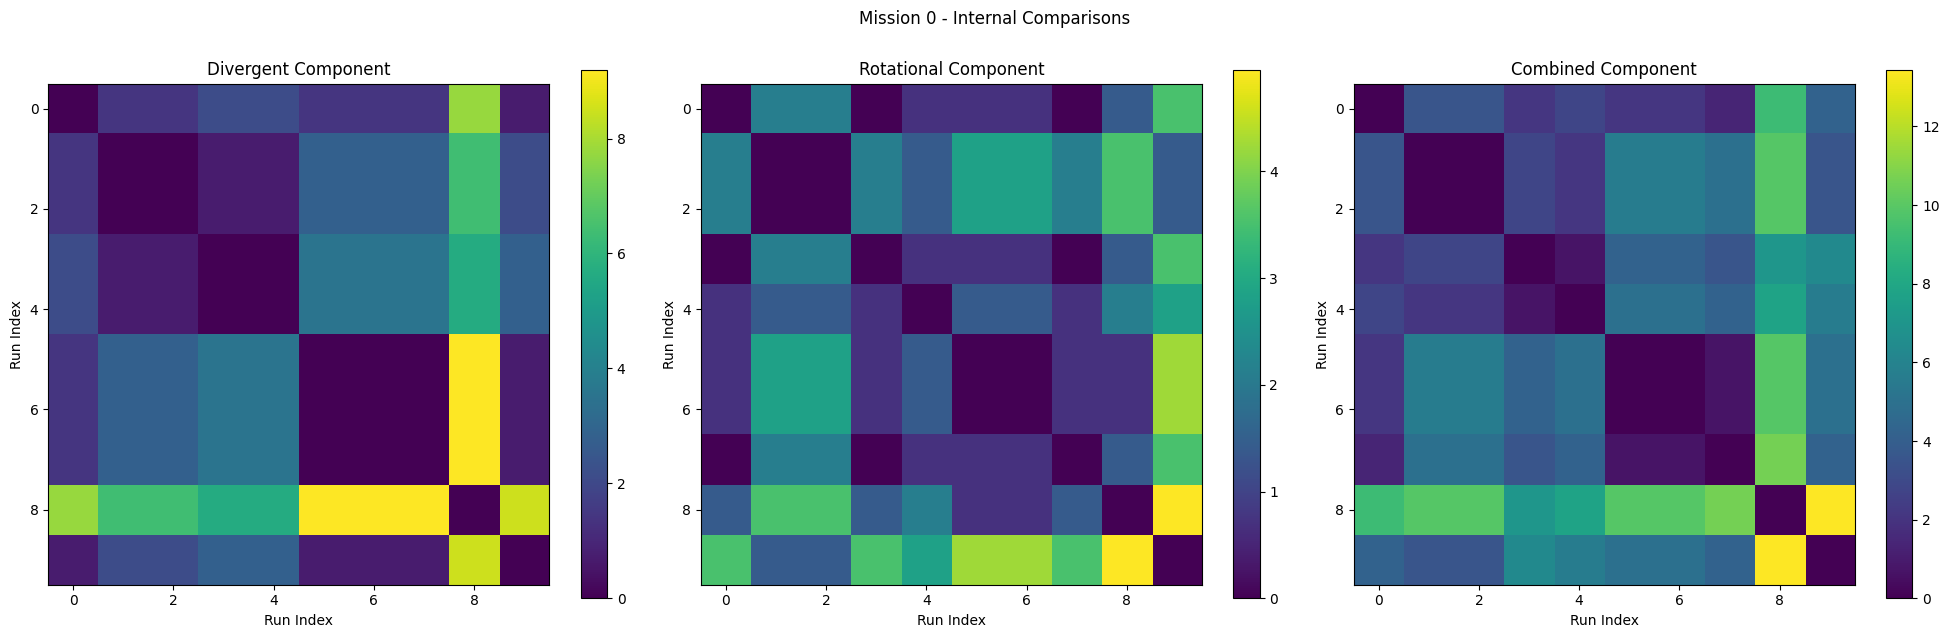

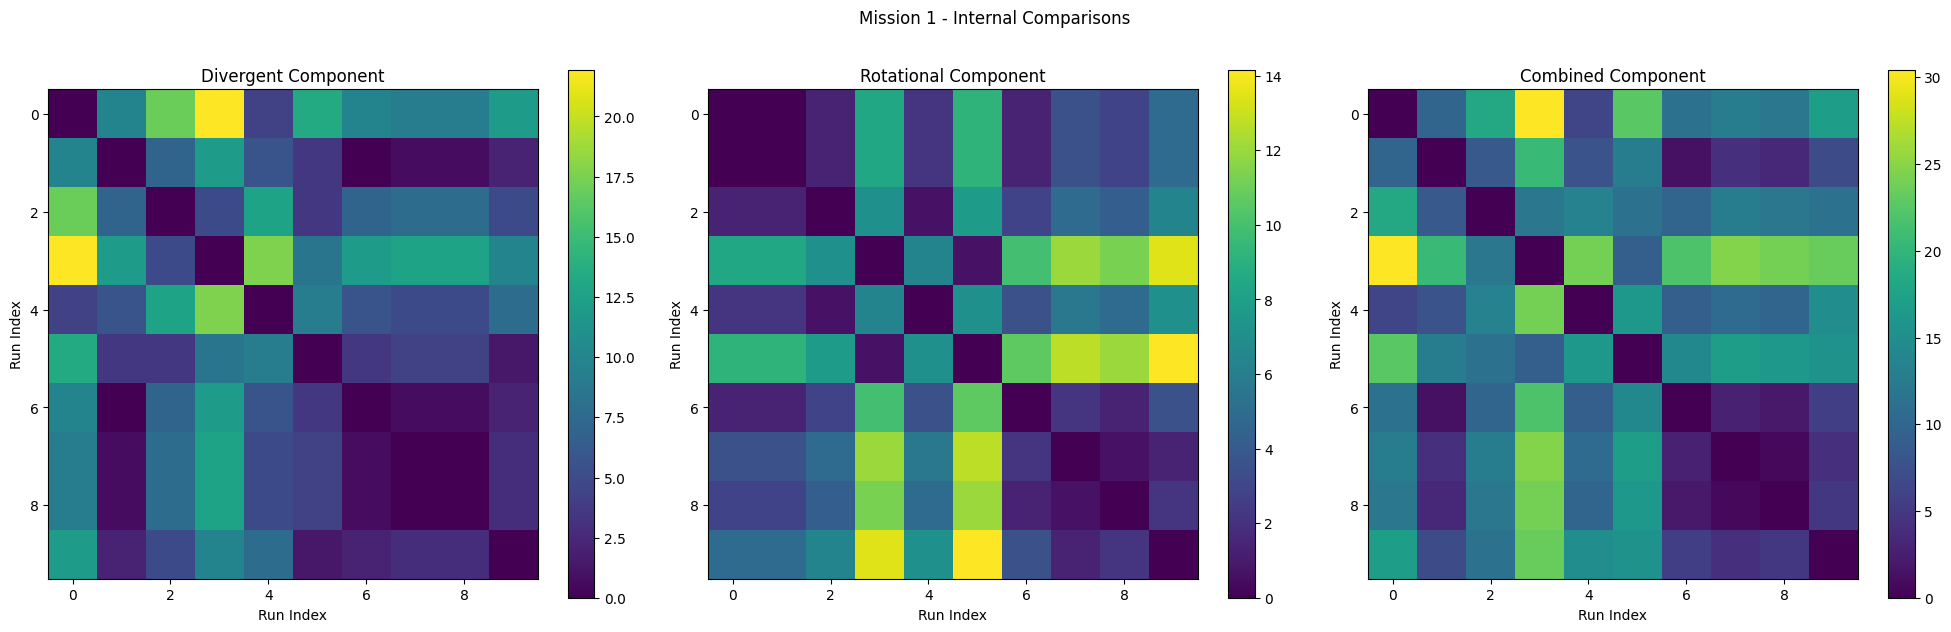

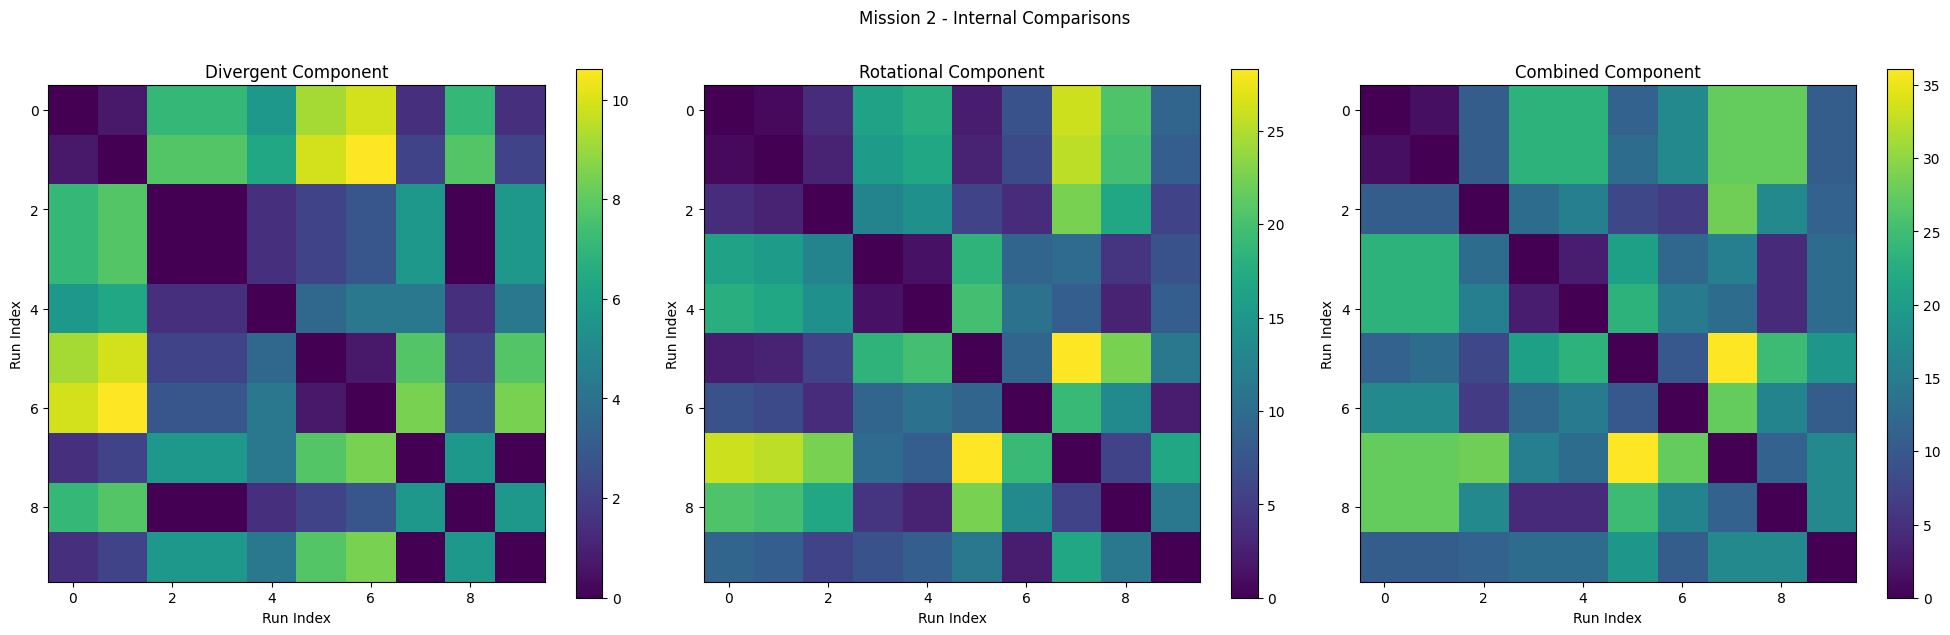

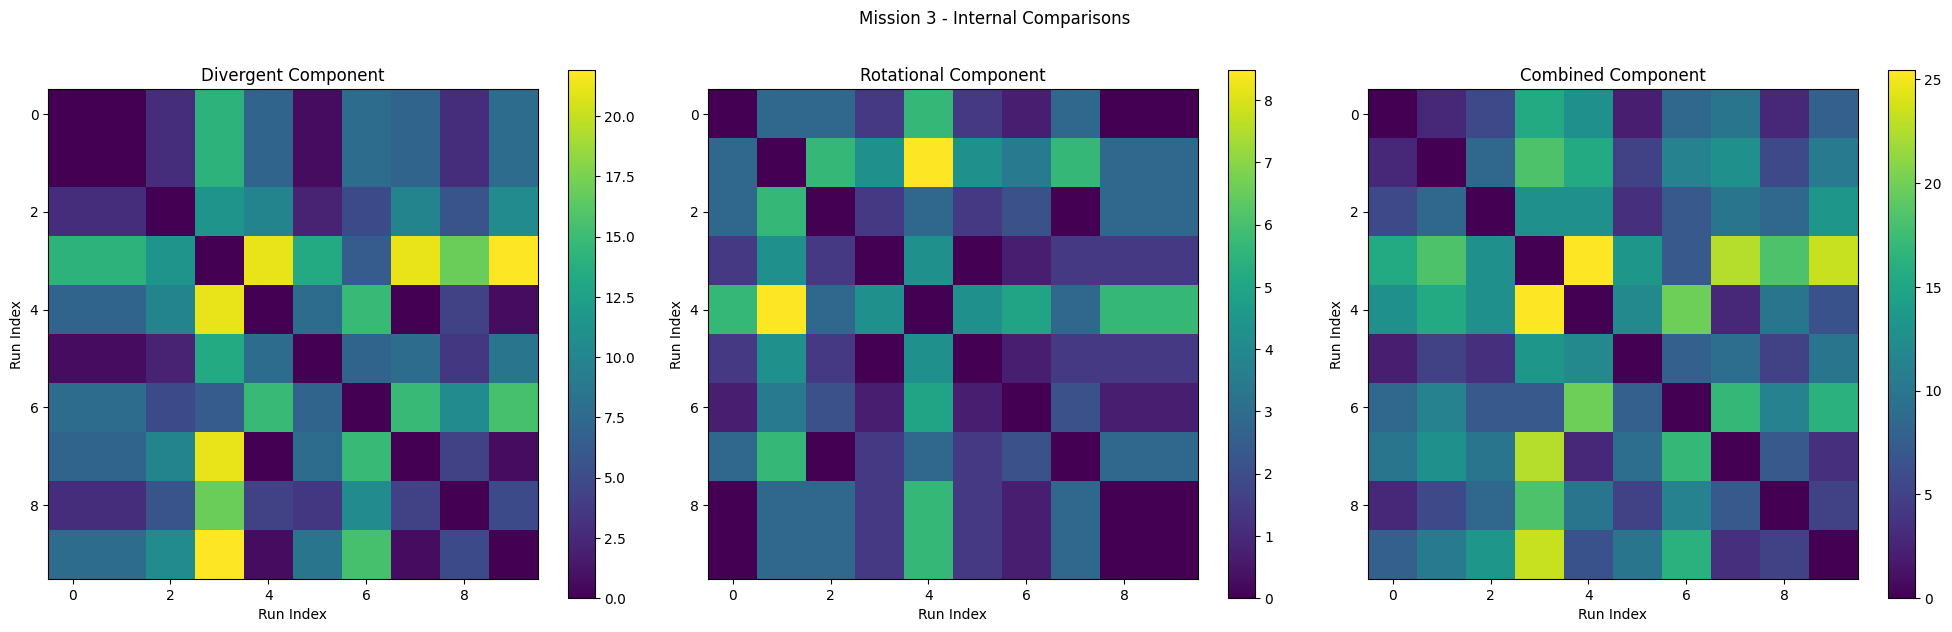

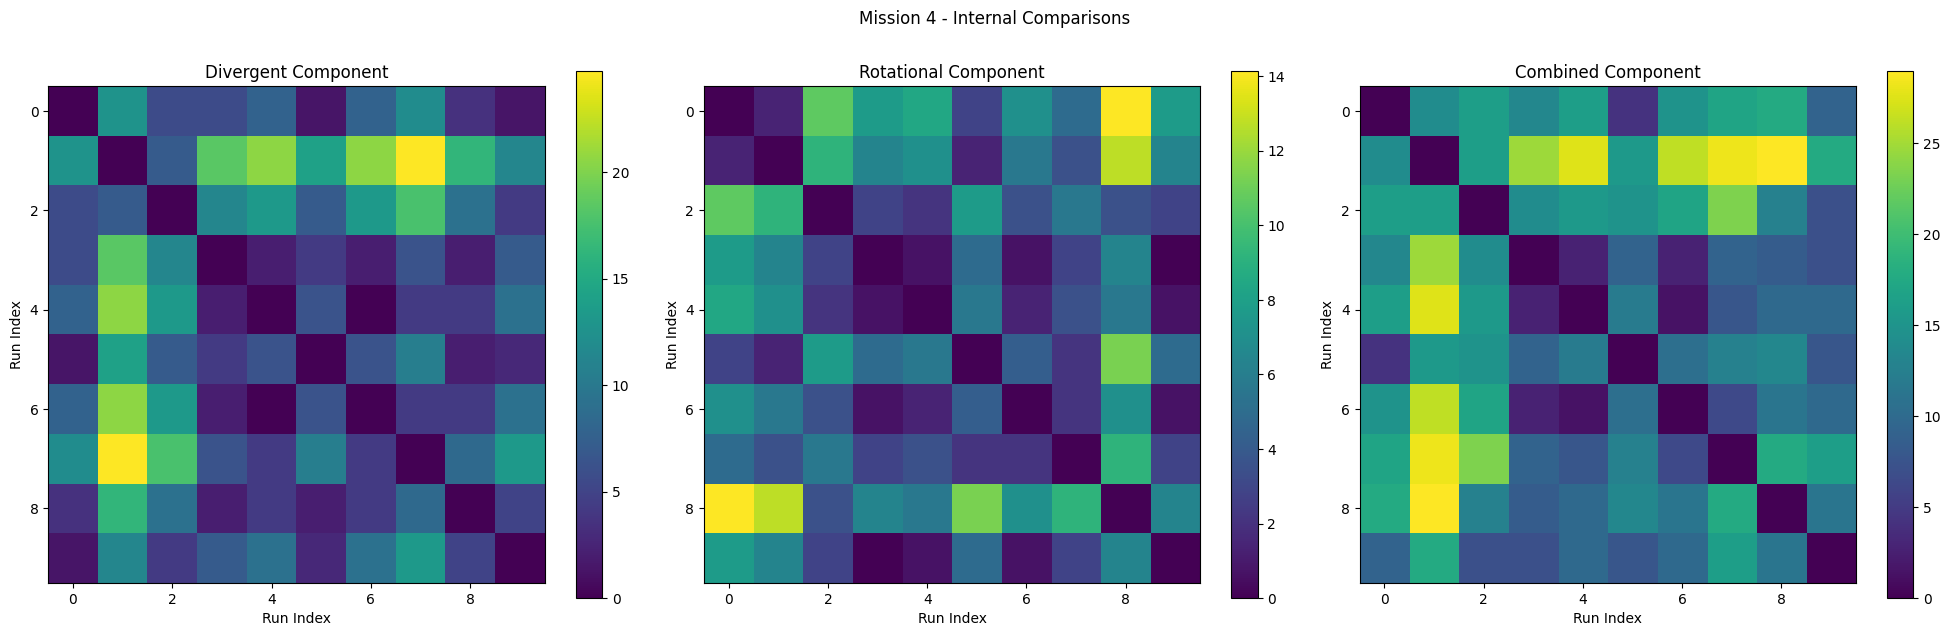

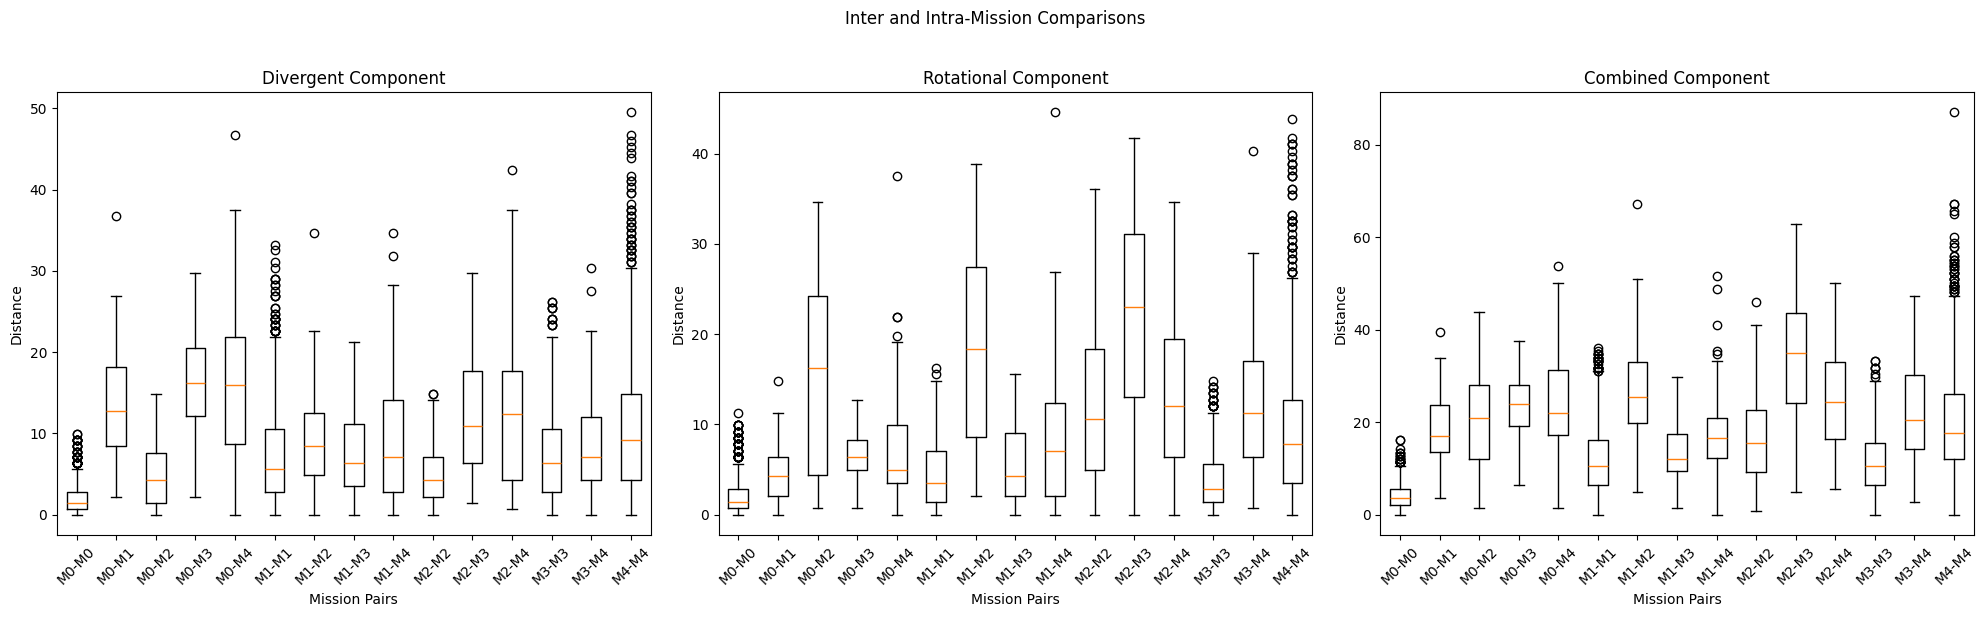

In [ ]:
from multiprocessing import Pool
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

def init_worker(shared_all_mission_data, shared_optimal_bin_width):
    global all_mission_data
    global optimal_bin_width
    all_mission_data = shared_all_mission_data
    optimal_bin_width = shared_optimal_bin_width

def process_batch(batch):
    """
    Processes a batch of comparisons.
    """
    results = []
    for mission1_idx, run1_idx, mission2_idx, run2_idx in batch:
        try:
            # Calculate the two components
            div_comparison = compare_analysis_cubical(
                all_mission_data[mission1_idx], run1_idx,
                all_mission_data[mission2_idx], run2_idx,
                optimal_bin_width, "Divergent"
            )
            rot_comparison = compare_analysis_cubical(
                all_mission_data[mission1_idx], run1_idx,
                all_mission_data[mission2_idx], run2_idx,
                optimal_bin_width, "Rotational"
            )

            results.append({
                'mission1': mission1_idx,
                'mission2': mission2_idx,
                'run1': run1_idx,
                'run2': run2_idx,
                'divergent': div_comparison['distances'],
                'rotational': rot_comparison['distances'],
                'combined': div_comparison['distances'] + rot_comparison['distances'],
                'for_heatmap': run1_idx < 10 and run2_idx < 10
            })
        except Exception as e:
            print(f"Error in comparison: {e}")
    return results

def create_batches(comparisons, batch_size):
    """
    Creates batches of comparisons.
    """
    return [comparisons[i:i + batch_size] for i in range(0, len(comparisons), batch_size)]

def analyze_all_missions_enhanced(all_mission_data, optimal_bin_width, n_runs_heatmap=10, 
                                  n_runs_boxplot=100, n_processes=None, batch_size=50):
    """
    Enhanced mission analysis with batch processing and optimized parallelization.
    """
    # Prepare all necessary comparisons
    comparisons_to_do = []

    # Intra-mission comparisons
    for mission_idx in range(5):
        for i, j in combinations(range(n_runs_boxplot), 2):
            comparisons_to_do.append((mission_idx, i, mission_idx, j))

    # Inter-mission comparisons
    for i, j in combinations(range(5), 2):
        for run_idx in range(n_runs_boxplot):
            comparisons_to_do.append((i, run_idx, j, run_idx))

    # Create batches
    batches = create_batches(comparisons_to_do, batch_size)
    print(f"Created {len(batches)} batches of size {batch_size}")

    # Initialize results
    results = {
        'intra_mission': {i: {'divergent': [], 'rotational': [], 'combined': []} 
                          for i in range(5)},
        'inter_mission': {'divergent': [], 'rotational': [], 'combined': []}
    }

    # Process batches in parallel
    print(f"Starting parallel computation with {n_processes} processes...")

    with Pool(processes=n_processes, initializer=init_worker, 
              initargs=(all_mission_data, optimal_bin_width)) as pool:
        for batch_results in tqdm(pool.imap_unordered(process_batch, batches), 
                                  total=len(batches), 
                                  desc="Processing batches"):
            # Process results from each batch
            for result in batch_results:
                if result is not None:
                    mission1, mission2 = result['mission1'], result['mission2']
                    if mission1 == mission2:
                        # Intra-mission results
                        for comp_type in ['divergent', 'rotational', 'combined']:
                            results['intra_mission'][mission1][comp_type].append({
                                'runs': (result['run1'], result['run2']),
                                'distance': result[comp_type],
                                'for_heatmap': result['for_heatmap']
                            })
                    else:
                        # Inter-mission results
                        for comp_type in ['divergent', 'rotational', 'combined']:
                            results['inter_mission'][comp_type].append({
                                'missions': (mission1, mission2),
                                'run': result['run1'],
                                'distance': result[comp_type]
                            })

    # Visualization code remains unchanged
    # Création des visualisations
    figs = {}
    
    # 1. Heatmaps pour chaque mission
    for mission_idx in range(5):
        fig = plt.figure(figsize=(20, 6))
        
        distance_matrices = {}
        for comp_type in ['divergent', 'rotational', 'combined']:
            matrix = np.zeros((n_runs_heatmap, n_runs_heatmap))
            for result in results['intra_mission'][mission_idx][comp_type]:
                if result['for_heatmap']:
                    i, j = result['runs']
                    dist = result['distance']
                    matrix[i, j] = dist
                    matrix[j, i] = dist
            distance_matrices[comp_type] = matrix
        
        titles = ['Divergent', 'Rotational', 'Combined']
        for idx, (comp_type, title) in enumerate(zip(['divergent', 'rotational', 'combined'], titles)):
            ax = fig.add_subplot(1, 3, idx+1)
            im = ax.imshow(distance_matrices[comp_type], cmap='viridis')
            plt.colorbar(im, ax=ax)
            ax.set_title(f'{title} Component')
            ax.set_xlabel('Run Index')
            ax.set_ylabel('Run Index')
        
        plt.suptitle(f'Mission {mission_idx} - Internal Comparisons', y=1.02)
        plt.tight_layout()
        figs[f'mission_{mission_idx}'] = fig
    
    # 2. Boxplots
    fig_box = plt.figure(figsize=(20, 6))
    
    for idx, comp_type in enumerate(['divergent', 'rotational', 'combined']):
        ax = fig_box.add_subplot(1, 3, idx+1)
        
        mission_pairs = [(i, j) for i in range(5) for j in range(i, 5)]
        mission_labels = [f'M{i}-M{j}' for i, j in mission_pairs]
        distances_per_pair = {pair: [] for pair in mission_pairs}
        
        for pair in mission_pairs:
            i, j = pair
            if i == j:
                distances = [result['distance'] 
                           for result in results['intra_mission'][i][comp_type]]
                distances_per_pair[pair].extend(distances)
            else:
                distances = [result['distance'] 
                           for result in results['inter_mission'][comp_type]
                           if result['missions'] == (i, j)]
                distances_per_pair[pair].extend(distances)
        
        box_data = [distances_per_pair[pair] for pair in mission_pairs]
        ax.boxplot(box_data, labels=mission_labels)
        ax.set_title(f'{comp_type.capitalize()} Component')
        ax.set_xlabel('Mission Pairs')
        ax.set_ylabel('Distance')
        plt.xticks(rotation=45)
    
    plt.suptitle('Inter and Intra-Mission Comparisons', y=1.02)
    plt.tight_layout()
    figs['boxplots'] = fig_box

    return results, figs

# Usage
if __name__ == '__main__':
    import multiprocessing
    n_cores = multiprocessing.cpu_count()

    # Adjust batch size according to your memory constraints
    batch_size = 5500  # You can fine-tune this value

    results, figures = analyze_all_missions_enhanced(
        all_mission_data,
        optimal_bin_widths,
        n_runs_heatmap=10,
        n_runs_boxplot=50,
        n_processes=n_cores - 1,
        batch_size=batch_size
    )

    # Save the figures
    for name, fig in figures.items():
        fig.savefig(f'{name}_comparison.png', bbox_inches='tight', dpi=300)


In [70]:
def analyze_multiple_runs_cubical(all_mission_data, pairs, optimal_bin_width,
                                 component_name="Divergent"):
     """
     Analyse plusieurs paires de runs avec l'approche cubique.
     """
     results = []
     
     for mission_idx1, run_idx1, mission_idx2, run_idx2 in pairs:
          comparison = compare_analysis_cubical(
                all_mission_data[mission_idx1], run_idx1,
                all_mission_data[mission_idx2], run_idx2,
                optimal_bin_width, component_name
          )
          
          results.append({
                'pair': (mission_idx1, run_idx1, mission_idx2, run_idx2),
                'distance': comparison['distances']
          })
     
     # Afficher un résumé des résultats
     print(f"\nRésumé des comparaisons pour {component_name}:")
     for result in results:
          m1, r1, m2, r2 = result['pair']
          print(f"Mission {m1} Run {r1} vs Mission {m2} Run {r2}: {result['distance']:.4f}")
     
     return results

# Comparons les deux approches sur un exemple
pairs = [
    (0, 0, 0, 1), 
    (0, 0, 0, 2),
    (0, 0, 0, 3),
    (0, 0, 0, 4),
    (0, 0, 1, 5),
    (0, 0, 2, 6),
    (3, 0, 3, 7),
    (3, 0, 1, 8),
    (3, 0, 2, 9),
    (3, 0, 3, 10),
    (3, 0, 4, 11),
    (3, 0, 1, 12),

]

results = analyze_multiple_runs_cubical(
    all_mission_data, 
    pairs, 
    optimal_bin_widths, 
    "rotational"
)

results = analyze_multiple_runs_cubical(
    all_mission_data, 
    pairs, 
    optimal_bin_widths, 
    "Divergent"
)


Résumé des comparaisons pour rotational:
Mission 0 Run 0 vs Mission 0 Run 1: 2.1213
Mission 0 Run 0 vs Mission 0 Run 2: 2.1213
Mission 0 Run 0 vs Mission 0 Run 3: 0.0000
Mission 0 Run 0 vs Mission 0 Run 4: 0.7071
Mission 0 Run 0 vs Mission 1 Run 5: 7.7782
Mission 0 Run 0 vs Mission 2 Run 6: 9.8995
Mission 3 Run 0 vs Mission 3 Run 7: 2.8284
Mission 3 Run 0 vs Mission 1 Run 8: 1.4142
Mission 3 Run 0 vs Mission 2 Run 9: 17.6777
Mission 3 Run 0 vs Mission 3 Run 10: 2.1213
Mission 3 Run 0 vs Mission 4 Run 11: 0.7071
Mission 3 Run 0 vs Mission 1 Run 12: 11.3137

Résumé des comparaisons pour Divergent:
Mission 0 Run 0 vs Mission 0 Run 1: 1.4142
Mission 0 Run 0 vs Mission 0 Run 2: 1.4142
Mission 0 Run 0 vs Mission 0 Run 3: 2.1213
Mission 0 Run 0 vs Mission 0 Run 4: 2.1213
Mission 0 Run 0 vs Mission 1 Run 5: 16.2635
Mission 0 Run 0 vs Mission 2 Run 6: 12.0208
Mission 3 Run 0 vs Mission 3 Run 7: 7.0711
Mission 3 Run 0 vs Mission 1 Run 8: 4.2426
Mission 3 Run 0 vs Mission 2 Run 9: 12.7279
Missio